In [20]:
import pandas as pd

df = pd.read_csv('Consumer_Complaints.csv', encoding='utf-8')
df['Product'] = df['Product'].astype(str)
df['Product'] = df['Product'].apply(lambda x :x.split(',')[0])
df['Product'] = df['Product'].apply(lambda x :x.replace('Money transferss', 'Money transfers'))
df.to_csv('Consumer_Complaints.csv', index=False, encoding='utf-8')

In [21]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310259 entries, 1 to 1094510
Data columns (total 18 columns):
Date received                   310259 non-null object
Product                         310259 non-null object
Sub-product                     258076 non-null object
Issue                           310259 non-null object
Sub-issue                       206641 non-null object
Consumer complaint narrative    310259 non-null object
Company public response         150060 non-null object
Company                         310259 non-null object
State                           309102 non-null object
ZIP code                        307615 non-null object
Tags                            53312 non-null object
Consumer consent provided?      310259 non-null object
Submitted via                   310259 non-null object
Date sent to company            310259 non-null object
Company response to consumer    310257 non-null object
Timely response?                310259 non-null object
Consumer 

In [23]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [24]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [25]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [26]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [27]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


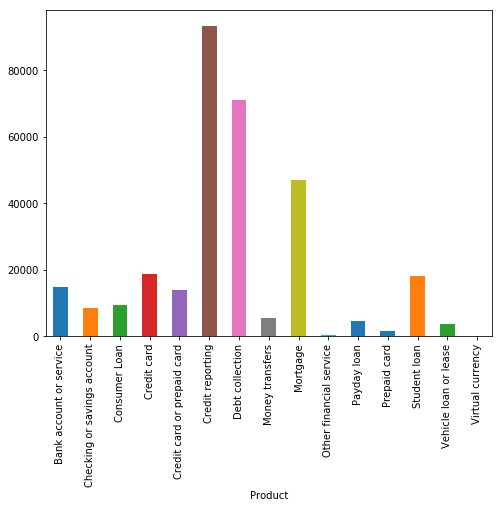

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(310259, 614055)

In [30]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Checking or savings account':
  . Most correlated unigrams:
       . overdraft
       . deposit
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . car loan
       . auto loan
# 'Credit card':
  . Most correlated unigrams:
       . macy
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . express
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . equifax xxxx
       . credit report
# 'Debt collection':
  .

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [32]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [33]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [34]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
12,Debt collection,This company refuses to provide me verificatio...,2


In [35]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
61,Credit reporting,I am disputing the inaccurate information the ...,0


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/cit/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


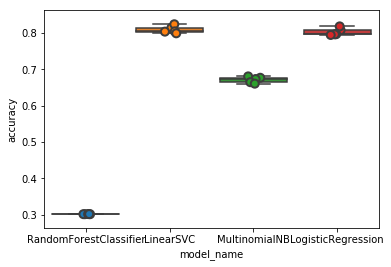

In [37]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [38]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.809333
LogisticRegression        0.802877
MultinomialNB             0.671248
RandomForestClassifier    0.301332
Name: accuracy, dtype: float64

In [39]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

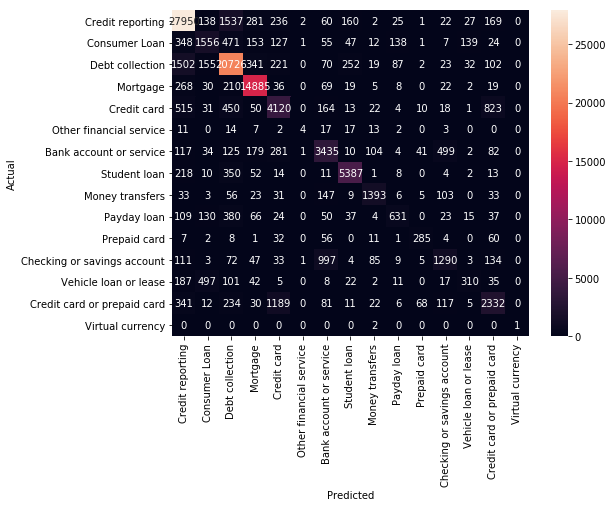

In [40]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Credit reporting' : 348 examples.


,Product,Consumer_complaint_narrative
824013,Consumer Loan,Mitsubishi is reporting me late on XXXX and ...
370897,Consumer Loan,I requested contracts bearing my signature and...
109323,Consumer Loan,this creditor ( turner acceptance corp ) has s...
470978,Consumer Loan,CAN AFFES CHARGE US XXXX PAYMENT ON A PAYMENT ...
360178,Consumer Loan,I checked my credit report only to find out th...
350885,Consumer Loan,Background : I filed Chapter XXXX BK in XX/XX/...
724531,Consumer Loan,Account number : XXXX I had a balance in XXXX ...
152092,Consumer Loan,Mariner Finance reported my account as closed ...
594915,Consumer Loan,Wells Fargo put an Hard inquiry on my XXXX and...
791124,Consumer Loan,I have a problem on credit i have identity the...



'Debt collection' predicted as 'Credit reporting' : 1502 examples.


,Product,Consumer_complaint_narrative
237760,Debt collection,I received a copy of XXXX credit report recent...
271232,Debt collection,I received a letter stating that I owe an amou...
5305,Debt collection,On XX/XX/2017 someone used my information to g...
180768,Debt collection,tere were several accounts opened in my name b...
862201,Debt collection,On XX/XX/2014 .AMOUNTS ARE $ XXXX.THIS IS PAYD...
220642,Debt collection,I received a credit alert from my credit monit...
386651,Debt collection,I have tried to contact Global credit to infor...
543528,Debt collection,I have requested removal of an item from my cr...
1069991,Debt collection,I filed an complaint against this company in X...
1065087,Debt collection,I have tried to contact Equifax several times ...



'Mortgage' predicted as 'Credit reporting' : 268 examples.


,Product,Consumer_complaint_narrative
882417,Mortgage,"Freedom Mortgage acquired my loan, which was o..."
715322,Mortgage,Attached you will find the new public records ...
145384,Mortgage,I have banked with Navy Federal Credit Union f...
879816,Mortgage,I was refused a Mortgage to buy a home XXXX XX...
1049588,Mortgage,Home Point Financial incorrectly reported my a...
371954,Mortgage,"Hello, this is in regards to : XXXX XXXX XXXX ..."
653965,Mortgage,I noticed a hard inquiry on my credit from XXX...
129600,Mortgage,i was paying my mortage on time through in my ...
94027,Mortgage,it took me 10years to fix my credit when up to...
933536,Mortgage,I have paid my Wells Fargo mortgage loan on ti...



'Credit card' predicted as 'Credit reporting' : 515 examples.


,Product,Consumer_complaint_narrative
677445,Credit card,"My first is XXXX, Last name : XXXX XXXX last X..."
262025,Credit card,BANK OF AMERICA HAS NUMEROUS FRAUD TRANSACTION...
204775,Credit card,I have permanently opted out of financial soli...
72166,Credit card,I was a victim of fraud and syncb wont reopen ...
85204,Credit card,I would like to dispute a Capital one Bank USA...
448852,Credit card,I disputed with the creditor directly ( see at...
582430,Credit card,This issue is that the subsidiary collection a...
11552,Credit card,Bank of America has re aged a charged off acco...
474042,Credit card,I went to my local Bank of America branch to o...
444359,Credit card,I inadvertently made XXXX {$100.00} payments t...



'Other financial service' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
127835,Other financial service,I was notified by a creditor that my personal ...
647574,Other financial service,The credit repair firm unauthorized my debit a...
713368,Other financial service,Springleaf Finance have XXXX hard inquiries on...
334081,Other financial service,I had a check made out to my son I was attempt...
822379,Other financial service,After reading all of the positive reviews from...
108574,Other financial service,Lexington Law advertised that they could help ...
716114,Other financial service,I went to annualcreditreport.com to help my st...
287971,Other financial service,I am highly dissatisfied with Lexington law fi...
90,Other financial service,i was tolled i would have a credit score of XX...
682557,Other financial service,on XXXX XX/XX/2016 i pay {$4.00} to Equifax to...



'Bank account or service' predicted as 'Credit reporting' : 117 examples.


,Product,Consumer_complaint_narrative
85467,Bank account or service,I confronted TDbank in XXXX ma. I explained th...
190432,Bank account or service,I applied for a BBVA Compass account and they ...
492576,Bank account or service,Vetting Agents - I was told to submit this way...
11872,Bank account or service,I would Like to open up a complaint On wells f...
41096,Bank account or service,I have been scammed out of my money and my ban...
315938,Bank account or service,I went to sign up for a PayPal account and lat...
474591,Bank account or service,I have XXXX personal loans with USAA Federal S...
627158,Bank account or service,Placed a call to customer service to learn why...
386093,Bank account or service,This account has been paid in full and should ...
572240,Bank account or service,"On XX/XX/XXXX, I placed a fraud alert on with ..."



'Student loan' predicted as 'Credit reporting' : 218 examples.


,Product,Consumer_complaint_narrative
4792,Student loan,Wells Fargo Student Loan reported for 4 years ...
831588,Student loan,This company has taken my 2017 tax refund and ...
47038,Student loan,Following is a copy of my most recent letter t...
913900,Student loan,"I have set up auto-pay twice with XXXX XXXX, o..."
1089675,Student loan,"While enrolled at XXXX XXXX University, my stu..."
955999,Student loan,XXXX has called me several times over the year...
601118,Student loan,My student loans are from my days at the Unive...
906037,Student loan,By law if you apply for a loan after 30 days o...
1064832,Student loan,I was reading my emails when I realized I had ...
937443,Student loan,Reporting missed payments on my credit report ...



'Money transfers' predicted as 'Credit reporting' : 33 examples.


,Product,Consumer_complaint_narrative
1082370,Money transfers,XXXX - XXXX. \n\nI sent {$180.00} and paid {$1...
1026172,Money transfers,An account was opened with Greensky Trade Cred...
395430,Money transfers,For years I 've never had a problem paying big...
1028843,Money transfers,I was signed out of my mobile app and when I a...
1064321,Money transfers,XXXX XXXX is working with several coin compani...
1074453,Money transfers,Nothing really happing I 'm a really good hard...
1037202,Money transfers,XXXX XXXX XXXX Clerk of Court RM:XXXX United S...
880420,Money transfers,I 've reported these fraud transactions to IRS...
195572,Money transfers,My mother purchased a money order with cash on...
507080,Money transfers,Paid this XXXX for assistance to help with bus...



'Payday loan' predicted as 'Credit reporting' : 109 examples.


,Product,Consumer_complaint_narrative
475929,Payday loan,Someone keep came and saying I am been sue for...
878294,Payday loan,I have an account with One Main Financial. The...
530261,Payday loan,"I applied for a loan for on XXXX XXXX, 2015 fo..."
978568,Payday loan,XXXX XXXX noticed unauthorized charges to Well...
886016,Payday loan,"Repeat issue. "" We expected some customer loss..."
185832,Payday loan,I have obtained a loan from Turbo Cash but the...
840921,Payday loan,For the past 2 years you have been reporting m...
1060980,Payday loan,my identity was stolen in XXXX 2017. Someone u...
114870,Payday loan,Please note this complaint is about being an i...
986663,Payday loan,"In talking to a customer service rep, I was as..."



'Prepaid card' predicted as 'Credit reporting' : 7 examples.


,Product,Consumer_complaint_narrative
720217,Prepaid card,My account was closed without notification and...
589542,Prepaid card,I tried 3 times with a lot of time to let them...
495468,Prepaid card,My card was lost while on vacation and I tried...
313149,Prepaid card,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
36357,Prepaid card,They add fees to this account
316053,Prepaid card,they promised me a XXXX credit comp and i sill...
367888,Prepaid card,"CITIBANK said I had a "" bankruptcy and your ac..."



'Checking or savings account' predicted as 'Credit reporting' : 111 examples.


,Product,Consumer_complaint_narrative
257991,Checking or savings account,I was trying to make a rent payment to my land...
1044275,Checking or savings account,I have sent Early Warning Services a validatio...
1008710,Checking or savings account,I have sent three certified mail in regards to...
1037995,Checking or savings account,XXXX XXXX XXXX I was falsely accused of elder ...
1052356,Checking or savings account,XXXX XXXX XXXX took over operations for XXXX X...
876686,Checking or savings account,Wrote Chex system a letter to remove accounts ...
1089786,Checking or savings account,id theft happen to my account cra violation in...
949434,Checking or savings account,This is basically a continuation of my CFPB ca...
1029372,Checking or savings account,Up until 2013 I was a customer of Bank of Amer...
843792,Checking or savings account,CitiBank/CitiGroup has instituted a policy tha...



'Vehicle loan or lease' predicted as 'Credit reporting' : 187 examples.


,Product,Consumer_complaint_narrative
695090,Vehicle loan or lease,Continued follow up to get the gross incompete...
880122,Vehicle loan or lease,I contacted Chase Auto Finance since my report...
1088300,Vehicle loan or lease,In short XXXX XXXX XXXX refused to offer me a ...
805676,Vehicle loan or lease,Ally fraudulently claims that I missed a payme...
801692,Vehicle loan or lease,"On XXXX / XXXX / XXXX , I contacted the my ..."
969750,Vehicle loan or lease,"In XXXX of this year, XXXX I sent a dispute to..."
844751,Vehicle loan or lease,"In XX/XX/XXXX, my XXXX XXXX was totaled in a h..."
887188,Vehicle loan or lease,"For XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, I paid..."
1045102,Vehicle loan or lease,obtained loan XX/XX/XXXX interest rate was ver...
821665,Vehicle loan or lease,I recently settled an old balance I had with ...



'Credit card or prepaid card' predicted as 'Credit reporting' : 341 examples.


,Product,Consumer_complaint_narrative
845628,Credit card or prepaid card,Chasee refuses to remove unverified and inaccu...
969522,Credit card or prepaid card,Initial credit limit was XXXX I opened account...
990446,Credit card or prepaid card,I have not used my credit card in a year since...
986659,Credit card or prepaid card,My identity was stolen 3 years ago. Some one o...
764229,Credit card or prepaid card,Date Opened : XX/XX/XXXX Account Name : APPLIE...
888356,Credit card or prepaid card,on XX/XX/XXXXa mastercard was closed by XXXX X...
1032608,Credit card or prepaid card,I have a loan with XXXX. I have always made my...
977764,Credit card or prepaid card,"Identity theft, known per local XXXX report XX..."
1072604,Credit card or prepaid card,I paid of my credit card account with a settle...
955649,Credit card or prepaid card,A hard inquiry was submitted on my XXXX credit...



'Credit reporting' predicted as 'Consumer Loan' : 138 examples.


,Product,Consumer_complaint_narrative
837147,Credit reporting,"I applied for a personal loan, not a title loa..."
812409,Credit reporting,I did a preliminary application with XXXX X...
49933,Credit reporting,It has been XXXX months since I filed a compla...
280364,Credit reporting,I was scammed by Ford Motor Credit. aprox X...
16920,Credit reporting,the XXXX sold me a car later they do n't want ...
953872,Credit reporting,I had a very unusual situation with Toyota Fin...
283032,Credit reporting,In XXXX I financed a motorcycle through Har...
924738,Credit reporting,This account with Ford was a lease. This accou...
305223,Credit reporting,We have a leased XXXX from toyota financial se...
865260,Credit reporting,"OnXXXX 2016, my Mercedes Benz lease was transf..."



'Debt collection' predicted as 'Consumer Loan' : 155 examples.


,Product,Consumer_complaint_narrative
439470,Debt collection,Wells Fargo Dealer Services is reporting wrong...
548585,Debt collection,I have an unsecured loan with BorrowersFirst a...
519411,Debt collection,The vehicle had {$1500.00} left on the loan an...
1045257,Debt collection,Owed 4000 on a car loan had horrible family is...
35863,Debt collection,I took a loan for XXXX paid off the loan of XX...
1030741,Debt collection,There is an automobile account that was opened...
278642,Debt collection,Delinquent on account due to husband losing jo...
836508,Debt collection,"On the XXXX of XXXX this year, we turned i..."
996476,Debt collection,"In XX/XX/XXXX, I purchased a car ( XXXX XXXX X..."
87239,Debt collection,I have a 60 day late notice on my credit score...



'Mortgage' predicted as 'Consumer Loan' : 30 examples.


,Product,Consumer_complaint_narrative
1027037,Mortgage,In XX/XX/XXXX I attempted to refinance my line...
600008,Mortgage,This complaint is against Springleaf Financial...
546327,Mortgage,I 'm requesting information about my loan to t...
1055439,Mortgage,During the buying processing of a home under c...
510131,Mortgage,If you make your payment on line and it is the...
253801,Mortgage,I have made my payments online through my XXXX...
102097,Mortgage,I believe I am a victim on predatory lending. ...
75430,Mortgage,I purchased my brother 's XXXX interest in my ...
85018,Mortgage,Principal balance as of XXXX/XXXX/15 was {$660...
607961,Mortgage,A Merged Infile Credit Report has continued si...



'Credit card' predicted as 'Consumer Loan' : 31 examples.


,Product,Consumer_complaint_narrative
85699,Credit card,I would like to bring to someone 's attention ...
113053,Credit card,My contact information Mailing address XXXX ...
202039,Credit card,We are a XXXX XXXX and were told by the store ...
771361,Credit card,I had a payment due for a line of credit from ...
771362,Credit card,Some how when I logged into PayPal I had a cre...
82923,Credit card,There was fraud committed against me in XXXX 2...
612942,Credit card,I would like your assistance in obtain feedbac...
51296,Credit card,I contacted Synchrony Bank because I found out...
386378,Credit card,I had a dispute for XXXX and they will not giv...
470292,Credit card,I signed up for a GE Care Credit Card and was ...



'Bank account or service' predicted as 'Consumer Loan' : 34 examples.


,Product,Consumer_complaint_narrative
627218,Bank account or service,Today I attempted to pay off a loan with BB & ...
247590,Bank account or service,This compliant is in regards to a business cre...
291879,Bank account or service,This is a notice to cease unauthorized inquire...
104032,Bank account or service,I feel like I was discriminated by TD bank in ...
750251,Bank account or service,I am a salesman for a local roofing and constr...
376332,Bank account or service,Wells Fargo continue to charge me late fees on...
293462,Bank account or service,Citibank Checking account balance falls negati...
202993,Bank account or service,I just read an article in the XXXX XXXX XXXX a...
789585,Bank account or service,Applied for loan for hot tub purchase from Wel...
18049,Bank account or service,have a personal loan with TD Bank terms are fi...



'Student loan' predicted as 'Consumer Loan' : 10 examples.


,Product,Consumer_complaint_narrative
118865,Student loan,My daughter has informed me that she has conta...
224550,Student loan,Well Fargo input my loan as a $ XXXX/month pay...
113625,Student loan,I 've been trying to get installment pymnts th...
1021213,Student loan,This is my second complaint against my loan se...
501371,Student loan,I use XXXX XXXX XXXX to pay for college. They ...
170869,Student loan,I received a prescreened offer from SoFi to re...
665195,Student loan,I had fallen behind on my loan and reached an ...
422390,Student loan,In XXXX of 2015 we sent in XXXX payments for b...
860367,Student loan,I have student loan with XXXX ( XXXX XXXX XXXX...
704960,Student loan,Monterey Financial has extracted a late fee fr...



'Payday loan' predicted as 'Consumer Loan' : 130 examples.


,Product,Consumer_complaint_narrative
876121,Payday loan,I got a personal loan from XXXX XXXX. I made a...
797610,Payday loan,"I have a loan with a "" company '' called XXXX ..."
956807,Payday loan,"I have a loan with personal finance in XXXX, I..."
660983,Payday loan,I 've just had to get my car repaired on credi...
103162,Payday loan,Received a check for {$1200.00} from Republic ...
622551,Payday loan,I just received a call from XXXX XXXX starting...
1058527,Payday loan,This is my third attempt in trying to resolve ...
5565,Payday loan,I have a loan through a loan company and they ...
241770,Payday loan,I took out an online loan in the amount of {$5...
280401,Payday loan,I received my loan from Title Max XXXX XX...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 497 examples.


,Product,Consumer_complaint_narrative
980639,Vehicle loan or lease,I bought a used XXXX XXXX and XXXX said they w...
943566,Vehicle loan or lease,"Hello, I received a letter some years ago stat..."
1043532,Vehicle loan or lease,Purchased a new vehicle and was financed throu...
822284,Vehicle loan or lease,In XX/XX/XXXX I received a used auto loan from...
1012535,Vehicle loan or lease,I obtained an auto loan with Capital One Auto ...
268775,Vehicle loan or lease,"I have an auto loan through Bank of America, I..."
995198,Vehicle loan or lease,On XXXX/XXXX/XXXX at the XXXX of XXXX dealersh...
939305,Vehicle loan or lease,My car was wrecked on XX/XX/XXXX and deemed a ...
800621,Vehicle loan or lease,My vehicle was repossessed in XX/XX/2015 in th...
581794,Vehicle loan or lease,I have a five year car loan with capital one b...



'Credit card or prepaid card' predicted as 'Consumer Loan' : 12 examples.


,Product,Consumer_complaint_narrative
996925,Credit card or prepaid card,Charge approximately % 2500- {$3000.00} per mo...
409339,Credit card or prepaid card,I paid {$700.00} on my Wells Fargo credit card...
1087332,Credit card or prepaid card,XX/XX/2017 I applied and was approved for a XX...
855275,Credit card or prepaid card,"On XX/XX/XXXX, I applied for a personal loan f..."
1079909,Credit card or prepaid card,In XXXX of 2016 I was late making my payment d...
1082670,Credit card or prepaid card,In XXXX of 2014 I went to Wells Fargo to apply...
985719,Credit card or prepaid card,Submitted paperwork to navy federal credit uni...
278498,Credit card or prepaid card,"Hi, I am complaining abou t the Paypal Credit ..."
972120,Credit card or prepaid card,Bank of America insisted that I make large pay...
875167,Credit card or prepaid card,Sychrony bank has misleading and fraudulent in...



'Credit reporting' predicted as 'Debt collection' : 1537 examples.


,Product,Consumer_complaint_narrative
879302,Credit reporting,I reviewed my credit report and noticed an err...
1049980,Credit reporting,Portfolio recovery debt buyer XXXX XXXX XXXX X...
947416,Credit reporting,"LVNV Funding, a company which I found out is w..."
773596,Credit reporting,There is an account listed that is not mine re...
153553,Credit reporting,will not remove XXXX or XXXX from report. \nco...
832553,Credit reporting,My issue is related to the cre ditor Bayview F...
361553,Credit reporting,Collection account was deleted from Jana Ferre...
1007650,Credit reporting,I have repeatedly contacted SCA Collections an...
971359,Credit reporting,My son moved to XXXX several years and termina...
940779,Credit reporting,A collection from diversified consultants was ...



'Consumer Loan' predicted as 'Debt collection' : 471 examples.


,Product,Consumer_complaint_narrative
213237,Consumer Loan,I went through debt consolidation with XXXX. O...
620647,Consumer Loan,A gentleman by the name of XXXX XXXX has been ...
417468,Consumer Loan,Midland Credit management sent me letters in X...
512898,Consumer Loan,I have a XXXX XXXX Financed through Santander ...
156847,Consumer Loan,XX/XX/2014 I received a letter from the IRS st...
382264,Consumer Loan,GM Financial has a fraudulent account in my na...
599490,Consumer Loan,I got a car through Drive time I am currently ...
441899,Consumer Loan,I entered into a car loan with Persian Accepta...
628899,Consumer Loan,"On my credit reports with XXXX, XXXX, and XXXX..."
476277,Consumer Loan,They are trying to damage my credit with a loa...



'Mortgage' predicted as 'Debt collection' : 210 examples.


,Product,Consumer_complaint_narrative
255606,Mortgage,We have tried to communication with our invest...
794119,Mortgage,I submitted a complaint on XX/XX/XXXX. I recei...
377972,Mortgage,"For months at a time, I recieved several phone..."
724007,Mortgage,Dyck O'neal Inc has continued to report rollin...
137607,Mortgage,I submitted a dispute on XXXX/XXXX/XXXX and I ...
568767,Mortgage,In XXXX XXXX Bank filed a foreclosure notice t...
368245,Mortgage,Residential Credit Solutions continues to wrec...
999435,Mortgage,I will also be filing complaints against the a...
268112,Mortgage,ON XXXX XXXX XXXX I was called by ...
533144,Mortgage,"Never missed a payment, nor have any payments ..."



'Credit card' predicted as 'Debt collection' : 450 examples.


,Product,Consumer_complaint_narrative
749781,Credit card,Although I disputed the amount I was charged a...
44354,Credit card,In XX/XX/2015 I purchased my very first home. ...
78055,Credit card,"I sent Bank of America a letter XXXX XXXX, XXX..."
580342,Credit card,GECRB/AMAZON PLCC has been reporting an accoun...
524621,Credit card,Had a credit card issue was sued by Daniels No...
476395,Credit card,"I am curious why my payment, again, is due bac..."
106369,Credit card,"Soon after making my payment to this company, ..."
306156,Credit card,This ( {$90000.00} ) XXXX XXXX XXXX Credit car...
285832,Credit card,I 'm being wage garnished and I 'm XXXX XXXX a...
51537,Credit card,An auto-dialer operated by or on behalf of Cap...



'Other financial service' predicted as 'Debt collection' : 14 examples.


,Product,Consumer_complaint_narrative
589743,Other financial service,"The post office destroyed my money order, maki..."
742210,Other financial service,we signed up with Global Client Solutions to c...
505420,Other financial service,I received a letter in the mail from Sofi or S...
689800,Other financial service,I sign on with ClearOne Advantage debt settlem...
404873,Other financial service,my fiance enrolled in this program being told ...
606112,Other financial service,"I find that this company, Riverwalk Debt Solut..."
362904,Other financial service,After talking to an XXXX XXXX employee and ans...
544577,Other financial service,MMI -- Money Management Incorporated has refus...
157002,Other financial service,I attempted to exchange euros to dollars at th...
93360,Other financial service,Pay-O-Matic cashed XXXX of our checks to a cus...



'Bank account or service' predicted as 'Debt collection' : 125 examples.


,Product,Consumer_complaint_narrative
452141,Bank account or service,We scheduled a time to open an IRA account for...
496694,Bank account or service,On XXXX a legal order XXXX with a number follo...
750830,Bank account or service,They closed our savings account down no explan...
1060035,Bank account or service,My husband and I opened an equity line of cred...
758178,Bank account or service,"In or around XX/XX/XXXX, I noticed that I had ..."
83257,Bank account or service,I 'm constantly getting calls from : XXXX XXXX...
185573,Bank account or service,The US bank continues harassing me with teleph...
435407,Bank account or service,"I been eating at XXXX for awhile, so today XXX..."
120486,Bank account or service,I filed a complaint with the CFPB about 2 year...
344221,Bank account or service,On XXXX XXXX XXXX this year I made a donation ...



'Student loan' predicted as 'Debt collection' : 350 examples.


,Product,Consumer_complaint_narrative
677930,Student loan,Navient has called and left a voicemail on a p...
853829,Student loan,Navient sent a notice on XXXX XXXX that they w...
272115,Student loan,FedLoan refuses to appropriately address its r...
1065401,Student loan,I was called by XXXX XXXX and told me that he ...
1051862,Student loan,They are calling my place of business and hara...
157293,Student loan,"About 2 months ago, I received a phone call fr..."
355393,Student loan,I received a called from The CBE GROUP INC in ...
845562,Student loan,I get 3-7 calls a day at all hours. I 've been...
578299,Student loan,"On Wednesday, XXXX/XXXX/16, I received a call ..."
10596,Student loan,My loan debt is zero. I 've received all lette...



'Money transfers' predicted as 'Debt collection' : 56 examples.


,Product,Consumer_complaint_narrative
1034674,Money transfers,I purchase ETH on XX/XX/XXXX for the amount of...
1088667,Money transfers,XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXXX CA XXXX...
429066,Money transfers,I made a payment of {$100.00} to XXXX ( email ...
855317,Money transfers,On X/XX/2017 Company : Global Payment deducted...
852684,Money transfers,This is to complain about BoA and XXXX using t...
292733,Money transfers,I was contacted by phone by XXXX XXXX XXXX XXX...
172582,Money transfers,I was told I would receive money from the gove...
969008,Money transfers,"On XXXX XXXX, I went to my local Walmart XXXX ..."
945445,Money transfers,Ca n't add XXXX to account online at XXXX XXXX
1017403,Money transfers,I do not know if you can help me or not. I dec...



'Payday loan' predicted as 'Debt collection' : 380 examples.


,Product,Consumer_complaint_narrative
993207,Payday loan,Active Hours said it would take up to 3 days t...
369540,Payday loan,I applied for XXXX payday loans for which I wa...
270433,Payday loan,Been paying this company 2 payments every 2 ...
247001,Payday loan,A loan worker calls me two to three times a da...
615557,Payday loan,calls more than 6 times a day sometimes automa...
265852,Payday loan,I have made 2 att empts with this company to ...
570313,Payday loan,Hello. My name is XXXX. I took out a payday lo...
286586,Payday loan,I took out a loan for {$260.00} and had to pay...
834880,Payday loan,"I made all XXXX payments - some were late, s..."
900629,Payday loan,I took out a Payday installment loan with Chec...



'Prepaid card' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
239145,Prepaid card,I brought a XXXX debit card. I loaded XXXX on ...
296396,Prepaid card,Have n't received any direct deposits in 4 weeks
262792,Prepaid card,I have been on the phone and ca n't get throug...
329338,Prepaid card,On XXXX/XXXX/16 I requested {$600.00} from an ...
729033,Prepaid card,My account was closed and I am still waiting f...
233020,Prepaid card,"My card/account was lock, and according to an ..."
405274,Prepaid card,I placed {$2000.00} on deposit was never paid ...
708597,Prepaid card,Did not authorize the account and customer ser...



'Checking or savings account' predicted as 'Debt collection' : 72 examples.


,Product,Consumer_complaint_narrative
793408,Checking or savings account,A perpetrator falsified my personal informatio...
1040573,Checking or savings account,A hold on membership with Navy Federal Credit ...
971739,Checking or savings account,I recently had a payment for a bill come out o...
1083589,Checking or savings account,I was sent a letter XX/XX/XXXX notifying me my...
954413,Checking or savings account,I got a letter in the mail saying that citi ba...
939847,Checking or savings account,"Hi, my name is XXXX XXXX. I work at XXXX XXXX ..."
265362,Checking or savings account,On XXXX approximately XXXX I call one of ...
1010538,Checking or savings account,To : Whom It May Concern My name is XXXX XXXX....
1039561,Checking or savings account,"In his XX/XX/XXXX letter, XXXX XXXX stated : ""..."
1033264,Checking or savings account,I was told over the phone with XXXX XXXX XXXX ...



'Vehicle loan or lease' predicted as 'Debt collection' : 101 examples.


,Product,Consumer_complaint_narrative
1062106,Vehicle loan or lease,"Talked with company, told the situation compan..."
978176,Vehicle loan or lease,I paid off my loan with XXXX XXXX XXXX on XXXX...
877999,Vehicle loan or lease,"CSC LOGIC inc, XXXX XXXX XXXXXXXX has several ..."
268289,Vehicle loan or lease,The aforementioned company Regions Bank violat...
267646,Vehicle loan or lease,My insuranse have diferernt lienholder the dmv...
987518,Vehicle loan or lease,XXXX XXXX ( # XXXX ) had my lease. Problem hap...
939750,Vehicle loan or lease,I have an auto loan with Wells Fargo Dealer Se...
1020390,Vehicle loan or lease,To Whom It May Concern : I was reviewing my cr...
882386,Vehicle loan or lease,Gm Financial continued to call me after inform...
1064899,Vehicle loan or lease,I returned a XXXX XXXX XXXX in XX/XX/XXXX. The...



'Credit card or prepaid card' predicted as 'Debt collection' : 234 examples.


,Product,Consumer_complaint_narrative
1092452,Credit card or prepaid card,XXXX 2017 XXXX credit card reward certificate ...
258327,Credit card or prepaid card,I went on a cruise wi th Carnival Cruise Lines...
810864,Credit card or prepaid card,I have a Chase credit card with a limit of {$1...
979933,Credit card or prepaid card,I purchased a 78inch Samsung TV from XXXX XXXX...
937256,Credit card or prepaid card,We purchased a Refrigerator from J.C Penny sto...
806811,Credit card or prepaid card,To Whom It May Concern : American Express has ...
948935,Credit card or prepaid card,XXXX XXXX XXXX threated to suit me ( XXXX XXXX...
1073901,Credit card or prepaid card,Formal Complaint against XXXX XXXX XXXX XXXX X...
1059475,Credit card or prepaid card,I got the attached document in the mail. I wor...
280320,Credit card or prepaid card,I have been in continuous written contact with...



'Credit reporting' predicted as 'Mortgage' : 281 examples.


,Product,Consumer_complaint_narrative
66065,Credit reporting,I am XXXX I went to hearing and provided paper...
834681,Credit reporting,Nationstar Mortgage Attn : XXXX XXXX XXXX Chai...
657073,Credit reporting,I filed bankruptcy in 2009. My bank that held ...
947398,Credit reporting,I had a mortgage with Ocwen Loan which was clo...
1006143,Credit reporting,"In XX/XX/2018, I brought my mortgage current b..."
800790,Credit reporting,In XX/XX/XXXX last year there were some hurric...
853261,Credit reporting,Bank of America is discriminating against busi...
268915,Credit reporting,"Hello, I started a loan modification on XXXX ..."
995146,Credit reporting,"Trying to get a mortgage, but because of the w..."
93379,Credit reporting,In XXXX XXXX we approached our mortgage lender...



'Consumer Loan' predicted as 'Mortgage' : 153 examples.


,Product,Consumer_complaint_narrative
594372,Consumer Loan,"On Saturday, XX/XX/2016 I tried paying auto no..."
550431,Consumer Loan,I have a Wells Fargo Home XXXX XXXX loan which...
149452,Consumer Loan,I was recently shopping for a pool loan and wa...
22034,Consumer Loan,"PenFed offers a hardship package, but does not..."
163447,Consumer Loan,"I have a loan with XXXX, which when first acqu..."
214044,Consumer Loan,"Bi Weekly payments of {$180.00}, i notified th..."
495937,Consumer Loan,I have a Home Equity Line of Credit with Chase...
3713,Consumer Loan,They added insurance without my permission and...
189633,Consumer Loan,Case number-XXXX.Thank you for taking the time...
123889,Consumer Loan,I paid my XXXX scheduled payment. I then sent ...



'Debt collection' predicted as 'Mortgage' : 341 examples.


,Product,Consumer_complaint_narrative
295169,Debt collection,In XX/XX/2016 my husband and I were closing on...
953683,Debt collection,"We received an email requesting "" Feedback abo..."
1088929,Debt collection,I settled this debt on XX/XX/XXXX. Requested a...
945855,Debt collection,XX/XX/XXXX myself and my ex-wife took out a ho...
388716,Debt collection,My current mortgage servicer is Selene Financi...
1049529,Debt collection,The debt is a mortgage. This debt was discharg...
998173,Debt collection,SEE ATTACHMENT. I AM A VICTIM OF IDENTITY THEF...
919467,Debt collection,The company refuses to enter the account into ...
834156,Debt collection,I am attempting to close out the estate of my ...
851063,Debt collection,HELOC through Suntrust mortgage was forgiven i...



'Credit card' predicted as 'Mortgage' : 50 examples.


,Product,Consumer_complaint_narrative
331686,Credit card,"Well, I have filed a compliant against Bank Of..."
615658,Credit card,I used one of the cash back deals from Bank of...
196899,Credit card,"On XXXX XXXX, 2016 XXXX submited a credit inqu..."
592167,Credit card,-- -- -- -- -- Forwarded message -- -- -- -- -...
624683,Credit card,"For the second time, Bank of America turned of..."
9905,Credit card,Citibank called XX/XX/XXXX to tell me the paym...
781105,Credit card,A Payment to Wells Fargo for the full balance ...
60283,Credit card,I have banked with Suntrust for almost 20 year...
721721,Credit card,Originally I filed a complaint under case numb...
723236,Credit card,I have XXXX separate credit cards that were wi...



'Other financial service' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
339458,Other financial service,We have been customers of Nationwide Biweekly ...
768796,Other financial service,nationwide biweekly with drew XXXX from my che...
487710,Other financial service,I had contacted Core Advisory about my mortgag...
705414,Other financial service,After many corporate vandals including XXXX XX...
258650,Other financial service,i hired Pay map company to collect my mortgage...
544550,Other financial service,I signed up with Nationwide Biweekly Administr...
354013,Other financial service,I asked Wells Fargo if they would accept a Dee...



'Bank account or service' predicted as 'Mortgage' : 179 examples.


,Product,Consumer_complaint_narrative
461373,Bank account or service,Made several attempts to pay mortgage via phon...
78512,Bank account or service,"WE have a loan with Champion Mortgage, XXXX Mi..."
361109,Bank account or service,I use the First Data Money Network card for my...
125645,Bank account or service,I refinanced my Fifth Third Home Equity Line o...
296277,Bank account or service,I LIVE IN A BANK OWNED HOUSE. I WANT TO BUY IT...
359534,Bank account or service,I am filing this complaint about PNC Bank for ...
353758,Bank account or service,I have had Nationwide BiWeekly Administration ...
611026,Bank account or service,We are in the midst of refinancing with Bank o...
312281,Bank account or service,Your Home Page is emblazoned with WE 'RE ON YO...
776334,Bank account or service,Ordered bank statements for XXXX-current and w...



'Student loan' predicted as 'Mortgage' : 52 examples.


,Product,Consumer_complaint_narrative
1068429,Student loan,I don't see this loan as useful anymore on my ...
52330,Student loan,In XXXX 2016 I responded to a message from Wel...
960081,Student loan,"On XXXX XXXX, I presented to bank of America, ..."
897874,Student loan,I went to XXXX in XX/XX/2008. I was charged a ...
485167,Student loan,My loan was purchased by Wells Fargo from my o...
624426,Student loan,MY INTEREST RATE IS THROUGH THE ROOF AND MY PA...
351818,Student loan,"I have been XXXX since 2007, contacted loan se..."
811771,Student loan,The loan was obtained under false pretenses th...
414951,Student loan,Over the past several years Wells Fargo has tr...
972386,Student loan,My tax refund was send to Navient and I reques...



'Money transfers' predicted as 'Mortgage' : 23 examples.


,Product,Consumer_complaint_narrative
992292,Money transfers,I opened account with them since this is the a...
639371,Money transfers,It all started with buying a condo. It 's my f...
890669,Money transfers,MB financial is not updating my information wi...
86141,Money transfers,"I was contacted by XXXX, XXXX XXXX, and asked ..."
173413,Money transfers,hello i am in the process of registering a com...
462193,Money transfers,I had a home security monitoring service from ...
389787,Money transfers,Lost $ XXXX down payment due to wire fraud. A ...
268372,Money transfers,I XXXX from XXXX XXXX XXXX where I...
794528,Money transfers,On XX/XX/XXXX I initiated a rollover procedure...
966482,Money transfers,XXXX. XXXX faxed insurance check to be cosigne...



'Payday loan' predicted as 'Mortgage' : 66 examples.


,Product,Consumer_complaint_narrative
803079,Payday loan,To Whom it may concern : This complaint is aga...
1045195,Payday loan,I applied for and received an unsecured person...
379752,Payday loan,"I have permanently "" opted out '' from unsolic..."
1017852,Payday loan,"On XXXX XXXX, XXXX, I opened a Revolving Line ..."
765808,Payday loan,Lender has contacted over XXXX times within a ...
1066574,Payday loan,I bought my 3-unit house back on XX/XX/XXXXwit...
1070744,Payday loan,I called boa several times to try and get my h...
816973,Payday loan,XXXX XXXX XXXX. XX/XX/2016 {$2400.00} to prese...
913825,Payday loan,Did n't work for a week now I ca n't borrow fr...
829726,Payday loan,> I purchased a XXXX XXXX from a private party...



'Checking or savings account' predicted as 'Mortgage' : 47 examples.


,Product,Consumer_complaint_narrative
968060,Checking or savings account,This relates to CFPB claim XXXX against People...
1057118,Checking or savings account,I made a mortgage payment on XX/XX/XXXX for {$...
1046922,Checking or savings account,This follows up on an earlier complaint I file...
1050943,Checking or savings account,I WAS TOLD THAT BECAUSE I AM A XXXX / XXXX PER...
899150,Checking or savings account,"XXXX XXXX, 2017, This is an addendum to a comp..."
997052,Checking or savings account,"I XXXX XXXX XXXXXXXX XXXX., was looking earn s..."
837240,Checking or savings account,We are in the midst of construction and realiz...
1090113,Checking or savings account,I scheduled two payments to be made by Wells F...
1052056,Checking or savings account,My name is XXXX XXXX and I am a XXXX XXXX with...
874599,Checking or savings account,Suffered a casualty loss to my home due to a h...



'Vehicle loan or lease' predicted as 'Mortgage' : 42 examples.


,Product,Consumer_complaint_narrative
1016749,Vehicle loan or lease,In XXXX I went into a Navy Federal Credit Unio...
928755,Vehicle loan or lease,We started a refinance with openroadlending. W...
951245,Vehicle loan or lease,This loan was for a XXXX XXXX boat. Early pay ...
976038,Vehicle loan or lease,You have illegally attempted to run my credit ...
999954,Vehicle loan or lease,My payment was {$540.00} a month was never lat...
982147,Vehicle loan or lease,On XX/XX/XXXX I received my payoff package in ...
887272,Vehicle loan or lease,I CONTACTED BANK OF THE WEST IN XX/XX/XXXX TO ...
1076770,Vehicle loan or lease,In early XX/XX/XXXX I began the process to ref...
894910,Vehicle loan or lease,"I have an RV loan with Bank of the West, and f..."
871328,Vehicle loan or lease,I purchased a XXXX fit at bud email XXXX in XX...



'Credit card or prepaid card' predicted as 'Mortgage' : 30 examples.


,Product,Consumer_complaint_narrative
999560,Credit card or prepaid card,Around XX/XX/2007 my wife XXXX XXXX and I appl...
1002087,Credit card or prepaid card,On XX/XX/XXXX I disputed the {$16000.00} amoun...
988458,Credit card or prepaid card,This is a complaint about TD bank 's online se...
1038955,Credit card or prepaid card,"On XX/XX/2018, I mistakenly paid my PayPal Cre..."
906201,Credit card or prepaid card,I have attempted to work with Bank of America ...
925938,Credit card or prepaid card,"This compliant is second submission, last XXXX..."
984985,Credit card or prepaid card,I filed a complaint against Bank of America wi...
1064757,Credit card or prepaid card,This is the second time that Bank of America h...
811527,Credit card or prepaid card,My case was closed today after the company pro...
833249,Credit card or prepaid card,"On XX/XX/XXXX, I made a timely online banking ..."



'Credit reporting' predicted as 'Credit card' : 236 examples.


,Product,Consumer_complaint_narrative
138551,Credit reporting,Item 1 : Use of Credit Score : It should be by...
1001968,Credit reporting,I paid my balance on my Wells fargo credit car...
111252,Credit reporting,I have a credit card with Capital One . I mad...
50216,Credit reporting,I stared XXXX dental treatment in XX/XX/XXXX. ...
968344,Credit reporting,I have 2 bank of america credit its closed but...
855667,Credit reporting,I added my cousin as an authorized user to my ...
167001,Credit reporting,Bank of America did not adjust my automatic pa...
934980,Credit reporting,This complaint if being filed on the advice of...
949309,Credit reporting,I filed a chapter XXXX bankruptcy in XXXX of 2...
877603,Credit reporting,I applied for a Capital One Venture Card and a...



'Consumer Loan' predicted as 'Credit card' : 127 examples.


,Product,Consumer_complaint_narrative
350321,Consumer Loan,Account number : XXXX I was shocked when I rev...
790189,Consumer Loan,Chrysler Capital has charged me a late fee for...
121684,Consumer Loan,I took an interest deferred loan with Wells Fa...
556853,Consumer Loan,I made a {$25.00} purchase on my Belk card in ...
411615,Consumer Loan,The last payment made on this Account was XXXX
67306,Consumer Loan,This complaint is against Chrysler Capital. I ...
934622,Consumer Loan,Paypal credit is asking for a high minimum pay...
711168,Consumer Loan,I sold my vehicle and was due a refund from Ch...
642699,Consumer Loan,Citbank just took over for Brooks Brothers cre...
519012,Consumer Loan,I have been receiving paper statements for my ...



'Debt collection' predicted as 'Credit card' : 221 examples.


,Product,Consumer_complaint_narrative
961069,Debt collection,XXXX & XXXX & XXXX ALL 3 CHASE CC FILED IN MY ...
900709,Debt collection,I called the credit card company fifth third b...
808643,Debt collection,Passed statue of limitation New Jersey Passed ...
986087,Debt collection,I need some help I have filed a bankruptcy and...
164603,Debt collection,I started GE money credit card for my teeth an...
726145,Debt collection,I am five days late paying my Macy 's card. I ...
425252,Debt collection,XXXX XXXX BANK AND CONTINENTAL FINANCE IS TRYI...
948786,Debt collection,"On XX/XX/2016, American Express reported on my..."
322809,Debt collection,We had a Capitol One Credit Card. My wife had ...
129455,Debt collection,Please look my previous cases I filled with th...



'Mortgage' predicted as 'Credit card' : 36 examples.


,Product,Consumer_complaint_narrative
726012,Mortgage,I overpaid WellsFargo the balance of my consur...
384438,Mortgage,XXXX/LenderLive wrongfully charged me a late f...
558107,Mortgage,requested credit report from XXXX on XXXX/XXXX...
705961,Mortgage,Tried paying my entire loan off XXXX times. Th...
118250,Mortgage,I was shocked when I reviewed my credit report...
506716,Mortgage,My payments was XXXX to HSBC and somehow a dif...
588633,Mortgage,I am writing you again for the XXXX time becau...
663985,Mortgage,I just days ago got from XXXX a credit report ...
348650,Mortgage,Today 's Date : XXXX/XXXX/2015 On XXXX/XXXX/15...
228949,Mortgage,I believe Fifth Third Bank if overcharging me ...



'Bank account or service' predicted as 'Credit card' : 281 examples.


,Product,Consumer_complaint_narrative
697677,Bank account or service,My Bank ( HSBC ) constantly shuts off my credi...
380471,Bank account or service,Bank of America made changes to its processes ...
783650,Bank account or service,I paid off XXXX of my credit card accounts wit...
593850,Bank account or service,"On Tuesday, XXXX XXXX I used Bank of America '..."
100809,Bank account or service,Dear Sir/Madam : This is letter in reference t...
753930,Bank account or service,Citibank breaches information. \nSince XXXX of...
307463,Bank account or service,"XX/XX/2016, I changed cable providers based on..."
451766,Bank account or service,Capital One Bank has been charging {$35.00} NS...
277317,Bank account or service,My husband had XXXX XXXX XXXX XX/XX/2010 with ...
72861,Bank account or service,On XXXX XXXX 2014 - I purchased a Sofa set onl...



'Student loan' predicted as 'Credit card' : 14 examples.


,Product,Consumer_complaint_narrative
648470,Student loan,Chase assessed {$2000.00} interest on a {$6000...
46489,Student loan,I called a number to get approved for XXXX XXX...
13205,Student loan,I do not receive statements/bills or any other...
167297,Student loan,"Balances out of control, high interest rates, ..."
384328,Student loan,Wellsfargo continuously misapplies payments an...
91683,Student loan,the amount does not go down and infact the amo...
1008193,Student loan,I was shocked when I reviewed my credit report...
209423,Student loan,"Well Fargo, where I have a private student loa..."
789194,Student loan,I recently requested a copy of my credit repor...
1063759,Student loan,I got the loan put on my credit card even thou...



'Money transfers' predicted as 'Credit card' : 31 examples.


,Product,Consumer_complaint_narrative
1068344,Money transfers,I sold an item on XXXX via PayPal and the buye...
1011378,Money transfers,I was trying to activate my US Bank Visa Card ...
895540,Money transfers,Prior to Coinbase notifying customers that the...
191532,Money transfers,"On XX/XX/XXXX, I contacted XXXX XXXX ( XXXX ) ..."
936614,Money transfers,"I have a paypal credit account, which used to ..."
899373,Money transfers,My customer filed a claim with his credit card...
846451,Money transfers,I was approved for XXXX dollars of line of c...
835329,Money transfers,We called Wells Fargo to do a foreign currency...
765480,Money transfers,I received an email from PayPal on XXXX XXXX s...
864720,Money transfers,I utilized paypal credit for their 6 months in...



'Payday loan' predicted as 'Credit card' : 24 examples.


,Product,Consumer_complaint_narrative
499834,Payday loan,I was tricked into signing up for Pay Pal cred...
834656,Payday loan,I 've been usin g PayPal for over 10 years so...
955355,Payday loan,I was shocked when I reviewed my credit report...
44247,Payday loan,PNC assessed a {$40.00} late fee despite being...
349363,Payday loan,Retired military do not keep dental coverage s...
1068553,Payday loan,My husband and I had a credit card each with X...
734830,Payday loan,Today I received a bill in the US mail from Pa...
269192,Payday loan,I went to XXXX XXXX aka XXXX i n ...
930438,Payday loan,On XX/XX/XXXX I cosigned a CareCredit account ...
88050,Payday loan,I responded to an offer by Citibank to pay off...



'Prepaid card' predicted as 'Credit card' : 32 examples.


,Product,Consumer_complaint_narrative
382974,Prepaid card,I have a XXXX Visa Citi debit cards ( $ 100/ca...
618497,Prepaid card,PayPower has failed to provide credit. Case nu...
463897,Prepaid card,XX/XX/XXXX I had used pay pal to purchase an i...
548108,Prepaid card,Irecieved a consumer credit report claiming I ...
493725,Prepaid card,I purchased an item from an online retailer us...
985,Prepaid card,US Bank Corp denied me the ability to rescind ...
784859,Prepaid card,I opened up a secure credit card after my rece...
48214,Prepaid card,Regarding American Express PASS card. I had se...
640468,Prepaid card,I attempted a purchase with a merchant for XXX...
605060,Prepaid card,I did not want this card. I tried to cancel/cl...



'Checking or savings account' predicted as 'Credit card' : 33 examples.


,Product,Consumer_complaint_narrative
805497,Checking or savings account,Hello I have been paying the credit card off f...
831018,Checking or savings account,HSBC changed their website to pay bills online...
258056,Checking or savings account,In XXXX M & T Bank sent a letter claiming t...
790611,Checking or savings account,"On the XX/XX/XXXX early afternoon PST, I was s..."
278016,Checking or savings account,"I lost my card, someone took XXXX $ off my c..."
923725,Checking or savings account,There are unauthorized payments coming from my...
881516,Checking or savings account,I received a letter from us bank stating that ...
889137,Checking or savings account,"According to federal consumer laws, mainly The..."
885884,Checking or savings account,"I have tried to call your customer service, bu..."
803764,Checking or savings account,I had checking account with Chase since 2013. ...



'Credit card or prepaid card' predicted as 'Credit card' : 1189 examples.


,Product,Consumer_complaint_narrative
932569,Credit card or prepaid card,This complaint is regarding the rental car ins...
1012842,Credit card or prepaid card,"My name is XXXX XXXX. \nAfter many, many offer..."
795646,Credit card or prepaid card,I wish to lodge a complaint about my Costco C...
1077908,Credit card or prepaid card,I banked with wells fargo since XX/XX/XXXX and...
1007474,Credit card or prepaid card,I initiated contact w JP Morgan Chase asking t...
907181,Credit card or prepaid card,I received a statement with an annual fee for ...
1021811,Credit card or prepaid card,I had Citi credit card for more than 10 years....
979580,Credit card or prepaid card,I applied for the Citibank XXXX XXXX XXXX XXXX...
1064234,Credit card or prepaid card,XXXX XXXX in XXXX XXXX Wisconsin from whom I p...
845592,Credit card or prepaid card,I have XXXX store credit cards with Synchron...



'Credit reporting' predicted as 'Bank account or service' : 60 examples.


,Product,Consumer_complaint_narrative
922234,Credit reporting,I received a legal order to hold funds in my a...
886830,Credit reporting,Last year pnc bank receive the money I paid wh...
322754,Credit reporting,I made a purchase at an XXXX XXXX XXXX on XXXX...
843636,Credit reporting,Wells Fargo Bank refuses to submit confirmatio...
882627,Credit reporting,Well back in XX/XX/2015 I was working a full t...
996955,Credit reporting,When I opened an account with XXXX XXXX of XXX...
270381,Credit reporting,"During XXXX XXXX , 201 6 Wells Fargo plac..."
45901,Credit reporting,I 've always had a rep payee and they have alw...
215421,Credit reporting,Bank of America is putting items on and off cr...
266147,Credit reporting,bank of america and XXXX XXXX XXXX violation ...



'Consumer Loan' predicted as 'Bank account or service' : 55 examples.


,Product,Consumer_complaint_narrative
661093,Consumer Loan,We traded in our vehicle and contacted the hol...
359319,Consumer Loan,I have sent CAPITAL ONE BANK legal documents l...
564217,Consumer Loan,I recently checked my credit reports as i have...
743060,Consumer Loan,It started with the need to get help for my ca...
297876,Consumer Loan,You have Ally bank listed twice on XXXX/XXXX/2...
571257,Consumer Loan,TD Bank consistently applies my payment signif...
536660,Consumer Loan,I co-signed for a auto loan for my daughter XX...
100448,Consumer Loan,This account originated with Wachovia Bank. At...
138249,Consumer Loan,Check n ' Go online continued to debit my acco...
799709,Consumer Loan,First merit only allows method of payment limi...



'Debt collection' predicted as 'Bank account or service' : 70 examples.


,Product,Consumer_complaint_narrative
547374,Debt collection,Telling me I have a returned item from my bank...
1034315,Debt collection,only {$190.00} was owed to Wells Fargo. not th...
73881,Debt collection,"Ally bank continues to call my cell phone, aft..."
835250,Debt collection,Every transaction i make gets detucted right a...
501957,Debt collection,I had an account with flagstar and had my chec...
968214,Debt collection,My husband passed away on XXXX XXXX XXXX. He w...
851047,Debt collection,THE GEORGIA DEPT OF HUMAN SERVICES HAS ILLEGAL...
378397,Debt collection,I received a notice on XX/XX/XXXX stating that...
1032655,Debt collection,my id was compromised by XXXX XXXX somehacker ...
907432,Debt collection,Wells Fargo Bank is still trying to collected ...



'Mortgage' predicted as 'Bank account or service' : 69 examples.


,Product,Consumer_complaint_narrative
737613,Mortgage,Have on the credit report that this is a joint...
371353,Mortgage,"On XXXX XXXX, 2016, my son passed away. His ho..."
298913,Mortgage,Wells Fargo Bank received and deposited insura...
441772,Mortgage,Bank of America automatically withdrew {$100.0...
31696,Mortgage,"Dear Officer, I am a loyal customer of Bank of..."
588636,Mortgage,Describe what happened so we can understand th...
220609,Mortgage,I refinanced my home mortgage in XXXX 2016 wit...
236005,Mortgage,I attempted to pay off a mortgage loan with Ch...
857069,Mortgage,BOA has refused to pay the settlement of this ...
752101,Mortgage,My husband and I had a home equity loan from S...



'Credit card' predicted as 'Bank account or service' : 164 examples.


,Product,Consumer_complaint_narrative
641858,Credit card,Can the bank charge you the new interest rate ...
79152,Credit card,All of my bank accounts at Chase had the money...
217596,Credit card,PayPal extended me a line of online credit wit...
437849,Credit card,I had XXXX credit cards with Chase. \nThey wer...
542502,Credit card,I have XXXX credit card accounts with Bank of ...
3775,Credit card,I have had Barclaycard since XXXX. I enjoy usi...
888578,Credit card,On XXXX XXXX someone made XXXX atm withdrawals...
371020,Credit card,A Paypal credit account was opened in my name ...
676513,Credit card,"As a background summary, I had an issue with f..."
655957,Credit card,On XXXX/XXXX/2016 contacted HSBC Bank to regis...



'Other financial service' predicted as 'Bank account or service' : 17 examples.


,Product,Consumer_complaint_narrative
463891,Other financial service,I entered a branch of Bank of America at XXXX ...
653229,Other financial service,I have tried several times to cash my paycheck...
530811,Other financial service,BackGround : I provided a real estate agent wi...
78488,Other financial service,Several checks were issued from XXXX for possi...
747324,Other financial service,"After applying for a job online, I received a ..."
408970,Other financial service,My husband and I sent 2 US postal service mone...
303280,Other financial service,I deposited a cashier 's check in Bank of Amer...
511988,Other financial service,"Dear CFPB, I contacted Bank of America to clos..."
396598,Other financial service,My payroll check was stolen and cashed by a th...
650697,Other financial service,My husband and I tried to cash a check from th...



'Student loan' predicted as 'Bank account or service' : 11 examples.


,Product,Consumer_complaint_narrative
1034690,Student loan,XXXX XXXX sent me a refund check in the mail f...
781318,Student loan,XXXX took {$6000.00} from my bank account last...
794998,Student loan,the lone has been given to G C services who ha...
267336,Student loan,My Granddaughter had me to cosign for her to g...
880121,Student loan,"For each monthly payment, a {$10.00} fee is as..."
447148,Student loan,I have been making payments since 2014 and hav...
409265,Student loan,Am not working full time! Have a part time job...
493368,Student loan,This claim is related to the complaint I filed...
1087570,Student loan,Student loan processor ( Heartland/ECSI ) char...
240955,Student loan,HELLO. I WOULD SOME INFO.HOW I CAN GET SOME HE...



'Money transfers' predicted as 'Bank account or service' : 147 examples.


,Product,Consumer_complaint_narrative
270294,Money transfers,I went to my ban k ( XXXX XXXX XXXX ) ...
984358,Money transfers,"On XX/XX/XXXX, I visited Bank of Americas fina..."
486341,Money transfers,I initiated a transfer of funds from two CD IR...
651118,Money transfers,As a XXXX retiree form a XXXX D.C.-based inter...
265415,Money transfers,"On XXXX XXXX , 2017 I had transferred {..."
981219,Money transfers,On XX/XX/XXXX I have scheduled ACH from my Che...
608086,Money transfers,The last XXXX to XXXX times I have used the Ch...
5548,Money transfers,"XXXX Money Lost for ever XX/XX/2016, an intern..."
804947,Money transfers,TD Bank is blocking my access through XXXX acc...
1066873,Money transfers,Transfer of IRA from Regions investment accoun...



'Payday loan' predicted as 'Bank account or service' : 50 examples.


,Product,Consumer_complaint_narrative
264068,Payday loan,I had received an offer for a personal loan f...
1008804,Payday loan,On XXXX XXXX 2015 I paid Wells Fargo Bank a pe...
982666,Payday loan,I attempted to close all of my accounts with K...
884994,Payday loan,"My personal loan lender, Wells Fargo Bank, ass..."
631559,Payday loan,My bank is XXXX in Illnois. I notified Essenti...
1010354,Payday loan,This is a follow up complaibt. If ypu log me o...
862099,Payday loan,I had a bank account with Wells Fargo Bank in ...
945598,Payday loan,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX #...
868559,Payday loan,PNC Bank re-activated an old line of credit ac...
1076323,Payday loan,Citizens Banks has engaged in a pattern and pr...



'Prepaid card' predicted as 'Bank account or service' : 56 examples.


,Product,Consumer_complaint_narrative
322010,Prepaid card,I bought a netspend debit visa card and they a...
180822,Prepaid card,"Paypal limited/froze my account on XXXX XXXX, ..."
519697,Prepaid card,In late XXXX of XXXX I received a letter from ...
99288,Prepaid card,When first opened the account there was a pref...
87400,Prepaid card,American Express Serve Acct. XXXX To whom it m...
145120,Prepaid card,I had an issue with my account due to a duplic...
935094,Prepaid card,I am very upset with this company. They have v...
390497,Prepaid card,I had XXXX dollars inside of my wallet with my...
130037,Prepaid card,I ordered a XXXX Tablet for {$53.00} at XXXX o...
469272,Prepaid card,Ingo money has closed my account for no reason...



'Checking or savings account' predicted as 'Bank account or service' : 997 examples.


,Product,Consumer_complaint_narrative
828412,Checking or savings account,"I had {$20.00} debited from my account for a ""..."
852697,Checking or savings account,I HAVE A COMPLAINT PENDING UNDER CASE NUMBER X...
1038843,Checking or savings account,On XXXX/XXXX/XXXX I noticed a charge on my acc...
821159,Checking or savings account,I had a pending transaction/bill payment from ...
942942,Checking or savings account,"On XXXX XXXX, XXXX at approximately XXXX I wen..."
259060,Checking or savings account,I have a recurring debit of {$12.00} that is b...
1063269,Checking or savings account,I use Regions Bank and have 2 checking account...
994253,Checking or savings account,I have called Wells Fargo multiple times and h...
804457,Checking or savings account,On XX/XX/2017 I transferred an IRA account fro...
970630,Checking or savings account,I wanted to lease a safety deposit box with TD...



'Vehicle loan or lease' predicted as 'Bank account or service' : 8 examples.


,Product,Consumer_complaint_narrative
830576,Vehicle loan or lease,I used Charles Schwab 's Bill Pay to make pa...
869954,Vehicle loan or lease,DISCRIMINATION Plaintiff : Company : XXXX XXXX...
886555,Vehicle loan or lease,When I signed my loan I originally agreed to e...
272202,Vehicle loan or lease,I paid off the loan and the bank continued to ...
999074,Vehicle loan or lease,The interest on the loan should have been lowe...
820191,Vehicle loan or lease,US bank intentionally misleads consumers to co...
800965,Vehicle loan or lease,On XX/XX/XXXX I contacted Ally Bank over the p...
997332,Vehicle loan or lease,I have been attempting to make my car payment ...



'Credit card or prepaid card' predicted as 'Bank account or service' : 81 examples.


,Product,Consumer_complaint_narrative
252578,Credit card or prepaid card,XX/XX/XXXX I went to my local Wells Fargo offi...
1025694,Credit card or prepaid card,I went into an HSBC bank to change my name aft...
978957,Credit card or prepaid card,Called XXXX XXXX on XXXX/XXXX/XXXX concerning ...
815918,Credit card or prepaid card,I had difficulty using my online app to make a...
899593,Credit card or prepaid card,The U.S. Bank charged me $ XXXX/per overdraft....
1080416,Credit card or prepaid card,I HAVE A CHARGE ON MY ACCOUNT THROUGH BANK OF ...
1057050,Credit card or prepaid card,I had a payment due on my Citi card. My accoun...
993321,Credit card or prepaid card,"ATTN : PPD Dispute, KEY BANK Dispute XXXX ( I ..."
255891,Credit card or prepaid card,I was alerted by the fraud department that my ...
271360,Credit card or prepaid card,"On XX/XX/XXXX, I made a {$330.00} payment to m..."



'Credit reporting' predicted as 'Student loan' : 160 examples.


,Product,Consumer_complaint_narrative
907385,Credit reporting,When I enrolled in university XXXX XXXX I was ...
1070422,Credit reporting,I co-signed on a student loan with Navient wit...
1004203,Credit reporting,"To whom it may concern, In the spring of XXXX,..."
63190,Credit reporting,"In XX/XX/XXXX, I received my first notificatio..."
1007675,Credit reporting,Attended XXXX XXXX for nothing school doesnt e...
1087067,Credit reporting,Navient student loans has indicated that I owe...
590615,Credit reporting,I have sent copies of documentation that I hav...
1057551,Credit reporting,I received a discharge on X/XX/2009 for total ...
767772,Credit reporting,Student loans are reporting late when they hav...
840175,Credit reporting,I was already enrolled in classes for the XXXX...



'Consumer Loan' predicted as 'Student loan' : 47 examples.


,Product,Consumer_complaint_narrative
749157,Consumer Loan,I am now out of work due to a XXXX and can not...
286857,Consumer Loan,I got a letter in the mail from Pioneer Credit...
77544,Consumer Loan,I 'm filing a complaint against Discover Perso...
782501,Consumer Loan,I went in to a motorcycle dealership to see if...
538080,Consumer Loan,XXXX loan was charged interest up front in add...
697088,Consumer Loan,I do n't understand why other loans with a due...
743216,Consumer Loan,My auto loan service provider refuses to follo...
221933,Consumer Loan,I received a XXXX loan to pay off debt. I was ...
395630,Consumer Loan,I was on an auto pay the last 18 months for a ...
662764,Consumer Loan,I paid this loan off in XXXX 2015. They proces...



'Debt collection' predicted as 'Student loan' : 252 examples.


,Product,Consumer_complaint_narrative
241765,Debt collection,"My Federal Loan Servicer, Great Lakes Educatio..."
151816,Debt collection,I attended XXXX XXXX XXXX XXXX and i paid mont...
14444,Debt collection,Clearview Resolution Services XXXX lied to my ...
52899,Debt collection,"Year XXXX, I activated a credit card through A..."
49759,Debt collection,this loan was received in 2000 for XXXX throug...
685044,Debt collection,I had XXXX loans with AES that were paid off b...
134504,Debt collection,"ACS is conducting substandard, if not illegal,..."
650277,Debt collection,I notified Chase that I did not wish to have a...
504130,Debt collection,I was sent a letter from XXXX XXXX Indicating ...
321640,Debt collection,XXXX XXXX was hired to collect for my XXXX del...



'Mortgage' predicted as 'Student loan' : 19 examples.


,Product,Consumer_complaint_narrative
211886,Mortgage,On XX/XX/2010 I sent SPS a letter and a copy o...
227219,Mortgage,unable to check my balance or any other inform...
67901,Mortgage,We got screwed over by Wells Fargo. We won the...
537564,Mortgage,I have been on a repayment program with Wells ...
450598,Mortgage,Upon calculation of our monthly interest we ha...
266203,Mortgage,I have a mortgage wit h PNC bank. in XXXX t...
39994,Mortgage,"With response to my claim # XXXX, I have made ..."
1008430,Mortgage,Primary Capital deposited my loan payment on X...
257046,Mortgage,"Payments post for the month, couple weeks late..."
927191,Mortgage,I have had an issue with City National Bank th...



'Credit card' predicted as 'Student loan' : 13 examples.


,Product,Consumer_complaint_narrative
737584,Credit card,WellsFargo Bank N.A. Credit Card Limit Increas...
341443,Credit card,A little over a year ago I enrolled in direct ...
754209,Credit card,Wells Fargo special interest free credit cards...
677361,Credit card,Late Payments Being Reported : 90 days past du...
164687,Credit card,I received a letter in the mail from CitiBank ...
471279,Credit card,Bank of America is forcing me to destroy my cr...
14182,Credit card,I have repeatedly set up my account for autopa...
199042,Credit card,I have a PayPal MasterCard account. I have bee...
26222,Credit card,I went through severe financial hardship after...
407912,Credit card,I would like to file a complaint about a repre...



'Other financial service' predicted as 'Student loan' : 17 examples.


,Product,Consumer_complaint_narrative
141990,Other financial service,I saw an ad on Facebook that a friend posted s...
86433,Other financial service,"In XXXX, I made the required number of payment..."
113840,Other financial service,I was charged XXXX by The Student Loan Help ...
483913,Other financial service,I used a company called FedLoanhelp.org to red...
86780,Other financial service,I received an email from representatives from ...
19544,Other financial service,I called a number that I found when I searched...
955107,Other financial service,I was contacted as soon as I graduated in XXXX...
705231,Other financial service,A third party debt relief service -Student Loa...
459701,Other financial service,I entered into an Agreement with Student Loan ...
98460,Other financial service,Company claiming to get my student loans reduc...



'Bank account or service' predicted as 'Student loan' : 10 examples.


,Product,Consumer_complaint_narrative
573416,Bank account or service,I opened an account with US Bank in XXXX 2010....
367157,Bank account or service,I have a contract with Wells Fargo Bank for an...
577032,Bank account or service,I paid my rent online through my resident acce...
538432,Bank account or service,Some years ago ( approximately 2010 ) I opened...
768513,Bank account or service,Sofi has ignored my request to stop sending me...
332559,Bank account or service,"BY CHANCE, I HAPPENED TO CHECK MY BANK STMT. F..."
60093,Bank account or service,I applied for a checking account with Discover...
500821,Bank account or service,"I made a student loan payment on time, receive..."
221845,Bank account or service,see attached. I am sending all info for this s...
396939,Bank account or service,I make monthly payments and my balance never d...



'Money transfers' predicted as 'Student loan' : 9 examples.


,Product,Consumer_complaint_narrative
964652,Money transfers,I was reached out to by the United Student Loa...
905911,Money transfers,On XX/XX/XXXX I signed a digital contract with...
1007021,Money transfers,Fraud/Scam. \n\nAn amount of {$39.00} was appl...
1025473,Money transfers,"I received a phone call on Monday, XXXX XXXX, ..."
795766,Money transfers,XX/XX/2018 ... XXXX XXXX a subsidy company of ...
967492,Money transfers,"On XXXX XXXX, I contacted the Premier Student ..."
908096,Money transfers,"In XX/XX/XXXX or XX/XX/XXXX, I was contacted r..."
1008666,Money transfers,This is a fradulant student loan consolidation...
850724,Money transfers,XXXX is not transferring my money to my new a...



'Payday loan' predicted as 'Student loan' : 37 examples.


,Product,Consumer_complaint_narrative
1044001,Payday loan,Nelnet Refuses To Mail Me A Paid In Full Lette...
834318,Payday loan,"Afte r Wells Fargo den ied my loan, I sent the..."
821434,Payday loan,I took out a loan with Wells Fargo Auto the lo...
848516,Payday loan,I can not afford my monthly payments. Previous...
807940,Payday loan,I ordered products online on 4 separate occasi...
1074869,Payday loan,"Student Loan ReFi ( # XXXX ) Unfortunately, I ..."
888128,Payday loan,Their daily interest system is not correct and...
1005446,Payday loan,I hated when you have go through the whole app...
791988,Payday loan,"I was injured on XXXX XXXX , 2016 . I made..."
755740,Payday loan,"I took out a XXXX loan in XXXX 2015, they were..."



'Vehicle loan or lease' predicted as 'Student loan' : 22 examples.


,Product,Consumer_complaint_narrative
872850,Vehicle loan or lease,I qualified for a deferment for my XXXX 2017 p...
1046555,Vehicle loan or lease,I was told I could change the date of my loan ...
963462,Vehicle loan or lease,I have a loan with XXXX. I have always made my...
843448,Vehicle loan or lease,"In 2017, I leased a car for XXXX. I am current..."
998830,Vehicle loan or lease,When attempting to post additional payments to...
929226,Vehicle loan or lease,My original monthly payment was {$870.00} on t...
1020216,Vehicle loan or lease,"After reviewing the loan with a banker, I real..."
969556,Vehicle loan or lease,"XXXX XXXX claims I am behind on a payment, spe..."
901179,Vehicle loan or lease,I have a boat loan with Key Bank. My boat is a...
881347,Vehicle loan or lease,I have been paying too the principal on my loa...



'Credit card or prepaid card' predicted as 'Student loan' : 11 examples.


,Product,Consumer_complaint_narrative
872791,Credit card or prepaid card,I submitted a previous complaint and I am not ...
1051757,Credit card or prepaid card,"Recently on XX/XX/2018, I spoke with a represe..."
884681,Credit card or prepaid card,"About a month ago, I requested, via email to X..."
922957,Credit card or prepaid card,I have a loan with XXXX XXXX XXXX. I have alwa...
811120,Credit card or prepaid card,I have a Citi Bank credit card that I have use...
906358,Credit card or prepaid card,I ca n't afford to make monthly payments on my...
989531,Credit card or prepaid card,My care credit account with XXXX XXXX refuses ...
1019021,Credit card or prepaid card,I was supposed to receive a direct deposit for...
273714,Credit card or prepaid card,"A short while after opening the XXXX account, ..."
977005,Credit card or prepaid card,5/3 recently updated their site to a different...



'Consumer Loan' predicted as 'Money transfers' : 12 examples.


,Product,Consumer_complaint_narrative
737332,Consumer Loan,I was offered a loan for XXXX dollars but in o...
563158,Consumer Loan,XXXX XXXX claimed he worked for BB & T said I ...
630801,Consumer Loan,I had a motorcycle financed through Synchrony ...
599147,Consumer Loan,I was contacted by someone named XXXX XXXX who...
233857,Consumer Loan,I was contacted by Star Cash XXXX XXXX at a ti...
621253,Consumer Loan,When making an online payment there is a multi...
511194,Consumer Loan,"I purchased golf shoes on ebay for {$100.00}, ..."
10743,Consumer Loan,I have a personal loan with SoFi. On XXXX XXXX...
98688,Consumer Loan,I never signed up for a Paypal loan. I did n't...
761771,Consumer Loan,This is a paypal line of credit that i was not...



'Debt collection' predicted as 'Money transfers' : 19 examples.


,Product,Consumer_complaint_narrative
34754,Debt collection,I completed a purchase through PayPal on XXXX/...
734892,Debt collection,My debt was paid by XXXX banks/XXXX and XXXX. ...
1044042,Debt collection,I do not have access to the dates the incident...
994231,Debt collection,I sold and mailed an item to a buyer using US ...
890760,Debt collection,I ordered an item from XXXX XXXX on XX/XX/2017...
967088,Debt collection,this is in reference to paypal.a backhoe was f...
650914,Debt collection,My parents have been receiving phone calls on ...
629642,Debt collection,PayPal continuously contacted XXXX XXXX about ...
456947,Debt collection,I am XXXX. I will try to get my point across. ...
870988,Debt collection,Last XX/XX/XXXXeye opened checking and saving ...



'Credit card' predicted as 'Money transfers' : 22 examples.


,Product,Consumer_complaint_narrative
131704,Credit card,I went on-line to get a balance transfer from ...
751733,Credit card,I sent money through money gram XXXX to XXXX X...
479192,Credit card,I have XXXX late payment notices on my credit ...
329834,Credit card,I used my credit card to purchase concert tick...
661232,Credit card,"On XXXX XXXX, we have taken out a credit accou..."
166664,Credit card,I have a XXXX account. I used it online to tra...
496462,Credit card,I recently received a phone call from PayPal C...
607184,Credit card,On XXXX there was a fraudulent online applicat...
370581,Credit card,My PayPal account has multiple unauthorized ch...
724691,Credit card,I disputed the purchase with Am/Ex as the item...



'Other financial service' predicted as 'Money transfers' : 13 examples.


,Product,Consumer_complaint_narrative
725966,Other financial service,"In XXXX, I purchased a {$60.00} MoneyGram mone..."
147006,Other financial service,My insurance company have issued check for car...
578751,Other financial service,I was awaiting a check in the mail. I received...
510994,Other financial service,Western Union send a XXXX form for the year 20...
171760,Other financial service,A MoneyGram Money Oder was received as a XXXX ...
74058,Other financial service,I was purchasing services from an XXXX seller ...
300500,Other financial service,On XXXX I stopped by the branch to purchase {$...
765566,Other financial service,i have purchased MoneyOrders from western unio...
566694,Other financial service,"Hello, I had processed a moneygram for a perso..."
95791,Other financial service,Received an e-mail from INGO.com online check ...



'Bank account or service' predicted as 'Money transfers' : 104 examples.


,Product,Consumer_complaint_narrative
368730,Bank account or service,XXXX wires were sent from XXXX via XXXX XX/XX/...
86939,Bank account or service,On XXXX/XXXX/15 I started an International Wir...
209744,Bank account or service,"On XXXX XXXX XXXX, I purchased a service contr..."
894098,Bank account or service,I used PayPal to invoice a client. The client ...
463404,Bank account or service,I purchased and item from a merchant and used ...
505580,Bank account or service,I wanted to transfer money to my parents for t...
412512,Bank account or service,I Have A Paypal Account And I Have Had It Ever...
498177,Bank account or service,My paypal account has been put in a negative b...
69001,Bank account or service,I received a voicemail with a time stamp of XX...
507738,Bank account or service,XXXX/XXXX/16 I got email from my bank about pe...



'Prepaid card' predicted as 'Money transfers' : 11 examples.


,Product,Consumer_complaint_narrative
754307,Prepaid card,"Western Union Prepaid XXXX XXXX, has extended ..."
246640,Prepaid card,"my paypal account was permanently limited, and..."
115946,Prepaid card,"Hello, I recently set up my first online busin..."
55138,Prepaid card,I have filed XXXX complaints with CFPB and hav...
776289,Prepaid card,Paypal is not allowing me to add money to my P...
1093212,Prepaid card,I tried to get a refund on {$4500.00} worth of...
702658,Prepaid card,My paypal account was permanently limited on X...
324090,Prepaid card,"On XXXX, I tried to wire money to Volkswagon C..."
82711,Prepaid card,My paypal account was permanently limited by P...
505916,Prepaid card,My PayPal account was permanently limited with...



'Checking or savings account' predicted as 'Money transfers' : 85 examples.


,Product,Consumer_complaint_narrative
264865,Checking or savings account,My intended recipient didnt receive my money (...
848171,Checking or savings account,"On XXXX XXXX, XXXX I, went to Capital One Bank..."
989295,Checking or savings account,OnXX/XX/XXXX my bank debit card was charged fo...
266477,Checking or savings account,"I have an account with Wells Fargo, I got mone..."
1023326,Checking or savings account,"This happened on today, XXXX XXXX 2017 at abou..."
1043199,Checking or savings account,On XX/XX/XXXX a wire was paid into my Chase Ch...
1057097,Checking or savings account,I was sent a wire transfer for XXXX but they o...
1047977,Checking or savings account,"On or about XXXX XXXX, I discovered that my ba..."
1012254,Checking or savings account,I have a bank account with JP Morgan Chase fro...
857609,Checking or savings account,"On XX/XX/XXXX, 2 unauthorized transfers out of..."



'Credit card or prepaid card' predicted as 'Money transfers' : 22 examples.


,Product,Consumer_complaint_narrative
990256,Credit card or prepaid card,I include attachment for successful purchase f...
1003056,Credit card or prepaid card,I never authorized PayPal to open and then clo...
1068424,Credit card or prepaid card,Unable to connect to a third party application...
1010749,Credit card or prepaid card,On XX/XX/XXXX I purchased an USED XXXX XXXX XX...
1056008,Credit card or prepaid card,THE BANK OF AMERICA SENT ME A BALANCE TRANSFER...
897213,Credit card or prepaid card,In XX/XX/XXXX I was contacted by a person on X...
955314,Credit card or prepaid card,"On Monday, XXXX XXXX, XXXX I contacted XXXX XX..."
1046690,Credit card or prepaid card,I purchased an automobile through XXXX XXXX bu...
852662,Credit card or prepaid card,On XXXX XXXX 2018 it was reported by the XXXX ...
841326,Credit card or prepaid card,Please connect to claim on XX/XX/18 number XXX...



'Credit reporting' predicted as 'Payday loan' : 25 examples.


,Product,Consumer_complaint_narrative
842872,Credit reporting,Hello I have a Fraud alert on my credit report...
947161,Credit reporting,Loan Company GREAT Plains Payday Lending who I...
1033675,Credit reporting,From the start I feel like they took advantage...
376700,Credit reporting,XXXX XXXX was notified of my filing with local...
874863,Credit reporting,"I am from Washington state, XXXX, I was borrow..."
893073,Credit reporting,I took out a personal loan for 36 months in XX...
1014478,Credit reporting,i 'm not sure if this is something wrong or wh...
168532,Credit reporting,Credit factors mentioned include finance loans...
795680,Credit reporting,I received a rejection letter from One Main Fi...
409437,Credit reporting,My name is XXXX XXXX XXXX. recently I checked ...



'Consumer Loan' predicted as 'Payday loan' : 138 examples.


,Product,Consumer_complaint_narrative
185866,Consumer Loan,I got a loan from Spot Loan a few months ago a...
388131,Consumer Loan,I expected to pay off the loan in 36 payments ...
529671,Consumer Loan,I took a loan out from Big Picture loans out o...
1067672,Consumer Loan,In XXXX of XXXX a fraudulent application for a...
121869,Consumer Loan,"On XXXX XXXX, 2015 I applied for an installmen..."
486131,Consumer Loan,I got a loan from lend up XXXX dollars till my...
178411,Consumer Loan,Issue with loan process and how things are han...
528760,Consumer Loan,My balance have not changed since 2012 ... nev...
13523,Consumer Loan,The sales representative stated multiple times...
182345,Consumer Loan,"# XXXXRise CreditXXXX XXXX XXXX XXXX, TX XXXX ..."



'Debt collection' predicted as 'Payday loan' : 87 examples.


,Product,Consumer_complaint_narrative
802182,Debt collection,Liberty Loan keeps contacting me in for a loan...
10320,Debt collection,XXXX is reporting a collection on my credit re...
835238,Debt collection,"On XX/XX/XXXX, I received a letter from : XXXX..."
594541,Debt collection,"High Point Asset, Inc. called saying that I ow..."
125281,Debt collection,I received a call from Critical Resolution Med...
387003,Debt collection,I took this installment payday XXXX/XXXX/15 in...
331577,Debt collection,Today-XXXX I received a Notice of Default and ...
370040,Debt collection,Someone has been calling my phone and family m...
117187,Debt collection,I am being contacted by Western who represents...
286729,Debt collection,This Company is reporting that I Obtained a Pa...



'Mortgage' predicted as 'Payday loan' : 8 examples.


,Product,Consumer_complaint_narrative
390802,Mortgage,i was approved for a line of credit with navey...
430881,Mortgage,"On XXXX XXXX 2002, I applied for a loan and wa..."
848671,Mortgage,Citibank line of credit My wife and I applied ...
762505,Mortgage,"Until XX/XX/XXXX, I was not aware that a loan ..."
28581,Mortgage,My loan is through PennyMac. I pay it at the e...
854641,Mortgage,I have tried calling/website/email. They said ...
527737,Mortgage,We made payment on our loan and out of {$320.0...
129571,Mortgage,I have taken a loan from bank of America for {...



'Student loan' predicted as 'Payday loan' : 8 examples.


,Product,Consumer_complaint_narrative
231703,Student loan,my student loan is now owned by naivent. The p...
257693,Student loan,I ca n't get any information on WHY loan balan...
968875,Student loan,i received a loan from the XXXX XXXX XXXX XXXX...
764446,Student loan,I was charged XXXX for a loan I did n't receive
871844,Student loan,I borrowed {$70000.00} to cover both XXXX and ...
876123,Student loan,Deceptive methods to get the loan processed pr...
406112,Student loan,I applied for a loan through SoFi. The adverti...
639265,Student loan,The longevity of my loan is excessive.



'Money transfers' predicted as 'Payday loan' : 6 examples.


,Product,Consumer_complaint_narrative
816691,Money transfers,I have signed up for a service through XXXX ...
1082101,Money transfers,I was involved in Ace cash express refund sett...
834374,Money transfers,I have an account with a payday lender and the...
220489,Money transfers,I solicited the services of a resume writing s...
1037664,Money transfers,I received a settlement check from Ace Cash Ex...
938996,Money transfers,PayPal Credit selling assets to XXXX XXXX and ...



'Checking or savings account' predicted as 'Payday loan' : 9 examples.


,Product,Consumer_complaint_narrative
928078,Checking or savings account,I currently use an app called XXXX which is a ...
949023,Checking or savings account,I received a loan from XXXX XXXX aka dba XXXX ...
851951,Checking or savings account,significant concerns about the banks new polic...
869352,Checking or savings account,Since XX/XX/XXXX Bank of America has charged m...
983766,Checking or savings account,ON XXXX I sent letters to XXXX all ACH debits ...
919727,Checking or savings account,"I spoke to my bank, PNC, regarding withdrawals..."
846798,Checking or savings account,I am extremely concerned with Bank of America ...
1063756,Checking or savings account,"I had requested a stop payment in XXXX 2017, t..."
853576,Checking or savings account,"I had gotten a payday loan, I lost my job and ..."



'Vehicle loan or lease' predicted as 'Payday loan' : 11 examples.


,Product,Consumer_complaint_narrative
838531,Vehicle loan or lease,On XX/XX/2017 my wife and I went to look into ...
918833,Vehicle loan or lease,On XX/XX/2017 I applied for a used car loan wi...
987874,Vehicle loan or lease,I work for XXXX XXXX XXXX XXXX and have been w...
919572,Vehicle loan or lease,I obtained a loan from GM Financial in XX/XX/2...
897628,Vehicle loan or lease,"I took out a loan for a vehicle in XX/XX/XXXX,..."
992689,Vehicle loan or lease,I purchased a XXXX XXXX XXXX XXXX XXXX purchas...
918018,Vehicle loan or lease,A payoff check was sent to Ally Financial the ...
922751,Vehicle loan or lease,I Had opened a loan amount of XXXX at TD bank ...
822358,Vehicle loan or lease,I received a loan from fifth third bank to pur...
1067355,Vehicle loan or lease,XXXX XXXX XXXX ( loan company ) and XXXX XXXX ...



'Credit card or prepaid card' predicted as 'Payday loan' : 6 examples.


,Product,Consumer_complaint_narrative
975249,Credit card or prepaid card,I have had numerous accounts with Conn 's in X...
935199,Credit card or prepaid card,i am writing you today because i was shocked w...
1051504,Credit card or prepaid card,GreenSky Credit and XXXX XXXX bad practice of ...
908032,Credit card or prepaid card,"On XXXX XXXX, 2017, I applied with Capital One..."
880800,Credit card or prepaid card,I have been contacting a company by the name o...
1063721,Credit card or prepaid card,on XXXX XXXX received a pre-qualified offer fo...



'Credit card' predicted as 'Prepaid card' : 10 examples.


,Product,Consumer_complaint_narrative
275968,Credit card,I have a visa Rushcard and they let some scamm...
342869,Credit card,I received an unsolicited 'NetSpend Prepaid XX...
1229,Credit card,I could add money on the XXXX card and then lo...
103002,Credit card,I used a XXXX gift card to make a purchase at ...
142592,Credit card,On XXXX i noticed that there was a transaction...
223303,Credit card,American Express Blue Bird XX/XX/2016 RE : Blu...
730326,Credit card,My American express serve card was stolen from...
127975,Credit card,I purchased a {$75.00} Amex prepaid gift card ...
168972,Credit card,my account was closed and no notification was ...
562633,Credit card,My card was stolen all of my money gone and. A...



'Bank account or service' predicted as 'Prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
787017,Bank account or service,American express reserve issues debit cards ba...
894892,Bank account or service,Previous case number is XXXX. \n\nBlackhawk Ne...
7165,Bank account or service,pay pal prepaid works with net spend and they ...
479117,Bank account or service,I call to American Express prepaid card on XXX...
491467,Bank account or service,Well first off i have a rushcard. I understand...
20341,Bank account or service,I loaded $ XXXX into my BBVA Compass Bank Clea...
618552,Bank account or service,As of XX/XX/XXXX I have been dealing with the ...
146959,Bank account or service,Rush card sent text messages telling all custo...
461157,Bank account or service,I have been a member with Rushcard for about t...
549642,Bank account or service,Rush card have cause my bills to be turned off...



'Credit card or prepaid card' predicted as 'Prepaid card' : 68 examples.


,Product,Consumer_complaint_narrative
1039429,Credit card or prepaid card,I received a prepaid reward American Express c...
931087,Credit card or prepaid card,In XX/XX/XXXX I purchased a reloadit pack for ...
1065101,Credit card or prepaid card,I have been actively using my XXXX XXXX XXXX X...
1042800,Credit card or prepaid card,XXXX XXXX is a prepaid card I received from my...
848574,Credit card or prepaid card,I have a American express prepaid gift card an...
828047,Credit card or prepaid card,This card was sent to me for no reason while I...
1061932,Credit card or prepaid card,The issue relates to a BlueBird by American Ex...
994947,Credit card or prepaid card,"Netspend prepaid cards, they have many XXXX XX..."
1001344,Credit card or prepaid card,On XXXX XXXX 2017 I tried to buy and put money...
947248,Credit card or prepaid card,On XX/XX/XXXX went online to access online ban...



'Credit reporting' predicted as 'Checking or savings account' : 22 examples.


,Product,Consumer_complaint_narrative
1068691,Credit reporting,Wells Fargo Opened a fraudulent loan under my ...
1083832,Credit reporting,I had deposited money in to my account where I...
930955,Credit reporting,I had a XX/XX/XXXX report at XXXX with XXXX XX...
1071856,Credit reporting,"From my understanding, my capital one 360 acco..."
848939,Credit reporting,XXXX XXXX which is with Wells Fargo originally...
913947,Credit reporting,I received my consumer report and it states I ...
900059,Credit reporting,Early Warning Systems stated I was in their da...
930275,Credit reporting,Compass bank continues to lie and slander my n...
1027960,Credit reporting,Nothing in the boxes covers my complaint but t...
1067146,Credit reporting,CITIBANK is A FRAUDULENT CRIMINAL AND USES WOR...



'Consumer Loan' predicted as 'Checking or savings account' : 7 examples.


,Product,Consumer_complaint_narrative
344565,Consumer Loan,XXXX I DEPOSITED A XXXX PARTY CHECK ( {$1900.0...
420890,Consumer Loan,The details are in the attached letter that wa...
596939,Consumer Loan,XXXX did not meet their delivery timeline. So ...
110373,Consumer Loan,Citizens One Banks wrongly clai ms my XXXX ...
146341,Consumer Loan,When I opened my auto loan with Wells Fargo I ...
761788,Consumer Loan,I got the loan in XXXX XXXX for an emergency h...
154406,Consumer Loan,I applied for a vehicle loan in XX/XX/XXXX wit...



'Debt collection' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint_narrative
803244,Debt collection,"0n XX/XX/2018, {$810.00} was taken from my che..."
940698,Debt collection,I was in a car accident with an enterprise ren...
838221,Debt collection,"Hello, I have a story for you. On XX/XX/XXXX a..."
865659,Debt collection,Chase bank unlawfully seized my funds and allo...
1062677,Debt collection,I 'm guessing someone opened an account in my ...
830819,Debt collection,I got a letter from a Debit Collecter Service ...
232744,Debt collection,I have already submitted earlier today a compl...
259129,Debt collection,"The XX/XX/2018 I received by US BANK an "" Sett..."
179945,Debt collection,HSBC refuses to communicate with XXXX XXXX XXX...
44954,Debt collection,When I was younger a man approached me and for...



'Mortgage' predicted as 'Checking or savings account' : 22 examples.


,Product,Consumer_complaint_narrative
839471,Mortgage,I would like to register a complaint against U...
958910,Mortgage,On XXXX XXXX 2017 I faxed an ACH Change Transf...
975801,Mortgage,XXXX XXXX has changed the CD and terms of this...
855529,Mortgage,TD Bank took an automatic withdrawal of {$1000...
805246,Mortgage,A time line is attached. My mother applied for...
97345,Mortgage,I refer to the letter dated XX/XX/2018 exchang...
268424,Mortgage,I filed a complaint against Bank of America Cr...
867472,Mortgage,the company XXXX XXXX XXXX withdrew my mortgag...
933177,Mortgage,I have been trying to access my account online...
100336,Mortgage,Hsbc informed me that they sent encrypted and ...



'Credit card' predicted as 'Checking or savings account' : 18 examples.


,Product,Consumer_complaint_narrative
786807,Credit card,I came into Bank of America to get my pin numb...
561714,Credit card,I opened a Target REDcard managed by TD Bank i...
1076464,Credit card,This has become an alaraming pattern of neglig...
704195,Credit card,"Following up on an already disputed issue, one..."
672681,Credit card,I got pick pocket out of the United States and...
238127,Credit card,In XX/XX/2016 I submitted XXXX payments to my ...
110693,Credit card,I was the victim of aggravated identity fraud ...
343642,Credit card,I opened an account with Chase on XX/XX/XXXX. ...
487087,Credit card,We have automatic payments that come out of ou...
176460,Credit card,On XX/XX/XXXX I had over XXXX worth of XXXX on...



'Bank account or service' predicted as 'Checking or savings account' : 499 examples.


,Product,Consumer_complaint_narrative
410231,Bank account or service,"On three occasions, I have requested that my d..."
370116,Bank account or service,I recieved a payment from a client through cre...
191209,Bank account or service,"On XX/XX/XXXX at XXXX, Bank of America was ord..."
363268,Bank account or service,"XXXX XXXX XXXX XXXX XXXX XXXX, NJ XXXX To whom..."
420931,Bank account or service,I have repeated ACH transactions being taken o...
380026,Bank account or service,I banked with Ally Bank from XXXX until XXXX X...
705541,Bank account or service,Electronic transfer from my XXXX XXXX XXXX sav...
738001,Bank account or service,"XXXX Financial Abuse from Checking, Savings an..."
17818,Bank account or service,On XX/XX/2017 my debit card was compromised wi...
1053736,Bank account or service,BBVA COMPASS HAS RESPONDED TO COMPLAINT BUT IS...



'Money transfers' predicted as 'Checking or savings account' : 103 examples.


,Product,Consumer_complaint_narrative
917197,Money transfers,I drove up to the ATM machine at the XXXX BB &...
896423,Money transfers,I have been using the app XXXX XXXX. There is ...
1053056,Money transfers,Bank of America is trying to use a 3 day float...
946549,Money transfers,OnXX/XX/XXXX I deposited a cashier 's check in...
986914,Money transfers,"On XXXX XXXX, XXXX we were taken in on an iden..."
1046914,Money transfers,SEE CFPB COMPLAINT LETTER ATTACHED FOR WORD FO...
1066772,Money transfers,I tried to sign up with XXXX using my Capital ...
1088678,Money transfers,On XX/XX/2017 I withdraw {$200.00} dollars ( X...
848999,Money transfers,I initiated papers to have a direct transfer f...
422205,Money transfers,Money was wired on XX/XX/XXXX. It is now XX/XX...



'Payday loan' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint_narrative
899793,Payday loan,I have a HELOC with PNC Bank with a credit lin...
104615,Payday loan,I have a checking account and HELOC at PNC B...
945401,Payday loan,I HAVE AN ACCOUNT WITH NORTHERN TRUST CO. BEIN...
542754,Payday loan,Lender charged my account when it was not expe...
1062553,Payday loan,Bank name : XXXX XXXX Name : XXXX XXXX Issue :...
1019956,Payday loan,Wells Fargo opened a fraudulent personal loan ...
847566,Payday loan,Upon reviewing information regarding my Self L...
1030203,Payday loan,On XX/XX/2018 Conns fraudulently submitted a p...
256931,Payday loan,I made the payment on XXXX XXXX i handed a...
950877,Payday loan,ON XX/XX/XXXX I ORDERED A XXXX XXXX XXXXXXXX I...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 17 examples.


,Product,Consumer_complaint_narrative
945542,Vehicle loan or lease,JP Morgan Chase Loan : XXXX Over the past two ...
275613,Vehicle loan or lease,I had filed a complaint previously. The banks ...
886277,Vehicle loan or lease,We purchased a car from XXXX of XXXX and finan...
1049896,Vehicle loan or lease,MY PROBLEM IS THAT SANTANDER CONSUMER IS RECEI...
1064432,Vehicle loan or lease,At the beginning of XX/XX/XXXX I contacted US ...
917035,Vehicle loan or lease,"XXXX XXXX, 2017 had car accident in a XXXX XXX..."
973106,Vehicle loan or lease,I previously submitted a complaint ( XXXX ) on...
1020817,Vehicle loan or lease,This complaint is in response to Wells Fargo r...
947920,Vehicle loan or lease,On XX/XX/XXXX I contact JP Morgan Chase Bank t...
925239,Vehicle loan or lease,I have a car loan with Ally Financial. We fell...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 117 examples.


,Product,Consumer_complaint_narrative
852776,Credit card or prepaid card,I failed to receive statements from Well Fargo...
1050903,Credit card or prepaid card,I opened a prepaid accou t with chase on or ar...
87745,Credit card or prepaid card,XXXX XXXX XXXX XXXX XXXX does not answer the p...
1087763,Credit card or prepaid card,TD Bank has twice turned down my claims for fr...
1034636,Credit card or prepaid card,One XX/XX/XXXX XXXX XXXX of XXXX XXXX XXXX XXX...
844835,Credit card or prepaid card,The nightmare started onXX/XX/XXXX when I acci...
918383,Credit card or prepaid card,chase let XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
965792,Credit card or prepaid card,On XXXX XXXX XXXX paid XXXX XXXX XXXX XXXX XXX...
959680,Credit card or prepaid card,Check fraud with XXXX XXXX Check ordering via ...
793910,Credit card or prepaid card,"On or about XXXX / XXXX / 17 , I applied for ..."



'Credit reporting' predicted as 'Vehicle loan or lease' : 27 examples.


,Product,Consumer_complaint_narrative
900364,Credit reporting,I recently did a lease buyout on my XXXX vehic...
915664,Credit reporting,GM Financial has been reporting my auto loan i...
136264,Credit reporting,I just found a multiple applied to different c...
808031,Credit reporting,"( 1 ) My problem is with XXXX XXXX, whom I hav..."
1010338,Credit reporting,"Leased ( Pre-Paid at signing XX/XX/XXXX = "" at..."
262605,Credit reporting,I am a XXXX XXXX XXXX XXXX with the State of A...
825549,Credit reporting,To Whom It May Concern.. \n\nXX/XX/XXXX XXXX a...
1086287,Credit reporting,"In XXXX XXXX, my XXXX XXXX XXXX was totaled an..."
47536,Credit reporting,XXXX have potentially negative on my account e...
222363,Credit reporting,On XX/XX/2017 I found a Hard inquiry from this...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 139 examples.


,Product,Consumer_complaint_narrative
303667,Consumer Loan,Horrible experience. Car repossessed after one...
24007,Consumer Loan,I challenge the adverse account designation of...
65528,Consumer Loan,I returned my mini cooper XXXX on XXXX/XXXX/XX...
790516,Consumer Loan,On XXXX I purchased a XXXX VW Jetta GLI from X...
679881,Consumer Loan,"Around XX/XX/XXXX, I purchased a brand new car..."
636311,Consumer Loan,I purchased a car XX/XX/XXXX and the loan was ...
164438,Consumer Loan,I am a single mother of XXXX who has been a lo...
344016,Consumer Loan,I Get a title load i dint reliced they give me...
469683,Consumer Loan,What Happened? \nI signed an Auto Lease with X...
495473,Consumer Loan,Ally bank was sued because they were charging ...



'Debt collection' predicted as 'Vehicle loan or lease' : 32 examples.


,Product,Consumer_complaint_narrative
574981,Debt collection,I purchased a used car and purchased Gap ins a...
314613,Debt collection,On XX/XX/2017 I spoke with a representative na...
1032007,Debt collection,I had a loan amount approved with Credit Accep...
248885,Debt collection,I bought a vehicle in 2012 and that vehicle wa...
973731,Debt collection,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S..."
842014,Debt collection,Called in to speak to NMAC Nissan acceptance m...
903711,Debt collection,Please note that I have filed other CFPB compl...
835235,Debt collection,I n XX/XX/XXXX I went to the XXXX dealersh...
833188,Debt collection,Calls twice a day with a recorded message that...
882310,Debt collection,"I admitted to debt for value received, then pr..."



'Payday loan' predicted as 'Vehicle loan or lease' : 15 examples.


,Product,Consumer_complaint_narrative
1091174,Payday loan,I bought a pickup from a person in Kansas. He ...
1083264,Payday loan,We obtained a lease from XXXX through a compan...
1012332,Payday loan,"Called company regarding the loan, no informat..."
852834,Payday loan,I got a loan with Loantopia in XX/XX/XXXX and ...
935971,Payday loan,We applied for a loan to build a pool . Aqua F...
164785,Payday loan,XX/XX/XXXX Emailed XXXX to inquire about how t...
1016782,Payday loan,My received a loan set off and determined by t...
1065841,Payday loan,Last month I spoke to a representative from th...
937923,Payday loan,Great American Finance acct XXXX open XX/XX/XX...
796930,Payday loan,On XX/XX/XXXX I had obtained a business loan...



'Credit reporting' predicted as 'Credit card or prepaid card' : 169 examples.


,Product,Consumer_complaint_narrative
1085219,Credit reporting,Bank of America Credit Card. Charge off date o...
980263,Credit reporting,I was shocked when I reviewed my credit report...
1092348,Credit reporting,I sent a certified goodwill letter to Capital ...
980931,Credit reporting,this complaint is regarding XXXX I had two iss...
790484,Credit reporting,It shows that my Chase Card account is open an...
1021865,Credit reporting,"I was dismayed once I looked at my XXXX, XXXX ..."
917572,Credit reporting,I have a merchant credit card with XXXX and Co...
866453,Credit reporting,Received letter from XXXX XXXX XXXX dated X/XX...
964774,Credit reporting,I opened an account with a bank institution an...
571628,Credit reporting,I opened a new credit account with XXXX XXXX X...



'Consumer Loan' predicted as 'Credit card or prepaid card' : 24 examples.


,Product,Consumer_complaint_narrative
313243,Consumer Loan,Capital One took an unauthorized payment from ...
630330,Consumer Loan,This complaint relates to a promotional balanc...
53177,Consumer Loan,i PURCHASED A XXXX MATTRESS SET AND THE XXXX X...
7110,Consumer Loan,I filed a dispute with AMERICAN EXPRESS in reg...
100701,Consumer Loan,This company is not being honest with me and i...
611902,Consumer Loan,I purchased furniture from Conns on XX/XX/XXXX...
562328,Consumer Loan,"Apply for course with XXXX XXXX XXXX XXXX, req..."
34103,Consumer Loan,"As a Wells Fargo checking, savings and auto lo..."
759785,Consumer Loan,On XX/XX/XXXX I bought {$4100.00} of Furniture...
481852,Consumer Loan,I was issued a credit card by First National B...



'Debt collection' predicted as 'Credit card or prepaid card' : 102 examples.


,Product,Consumer_complaint_narrative
1050169,Debt collection,"Hello, This has been an ongoing issue since XX..."
505330,Debt collection,This company called XXXX was suppose to design...
1076743,Debt collection,I closed my capital one account on XX/XX/XXXX....
897071,Debt collection,I was being proactive and reached out to the c...
971738,Debt collection,bank of America XX/XX/17 account opened in my ...
1083197,Debt collection,XX/XX/2007 {$1000.00} I was making payments an...
504063,Debt collection,I discovered on my credit report Wells Fargo i...
820209,Debt collection,SUMMARY OF EVENTS ( Please see Appendix for mo...
1040622,Debt collection,"Good afternoon, I had a XXXX credit card accou..."
999083,Debt collection,Complaint # XXXX was not addressed at all in N...



'Mortgage' predicted as 'Credit card or prepaid card' : 19 examples.


,Product,Consumer_complaint_narrative
1069431,Mortgage,We are platinum members with XXXX XXXX with cu...
1041002,Mortgage,I received a letter on XXXX-XXXX-2018 from Cit...
555874,Mortgage,Upon trying to setup my account information af...
351526,Mortgage,I applied for credit and was declined but neve...
272351,Mortgage,"I made a paym ent XXXX XXXX 2017, whi c..."
985266,Mortgage,I have a loan with PRIMARY RESIDENTIAL MORTGA....
924112,Mortgage,"Dear, usually my payment due date is about XXX..."
868897,Mortgage,"We attended a very high pressure sales and "" o..."
828219,Mortgage,"XXXX I have sent the same below to XXXX ,..."
182866,Mortgage,Reference your complaint number XXXX. In regua...



'Credit card' predicted as 'Credit card or prepaid card' : 823 examples.


,Product,Consumer_complaint_narrative
18150,Credit card,"Good day, I paid my XXXX Master Card, under Co..."
876149,Credit card,"In XXXX 2017, I applied for a XXXX XXXX XXXX c..."
228081,Credit card,"On XXXX/XXXX/XXXX a "" Small Balance Adjustment..."
496249,Credit card,I checked my credit score from an e-mail from ...
707359,Credit card,My closing agent mailed XXXX checks to payoff ...
734564,Credit card,After open a business account for a new busine...
865195,Credit card,I HAVE HAD A VISA MERRILL + CREDIT CARD FOR MA...
467061,Credit card,Emerge Credit Card has been charging me 29.99 ...
661247,Credit card,I held a citi double cash rewards which i canc...
384238,Credit card,"Hello, I have been a credit card member of Dis..."



'Bank account or service' predicted as 'Credit card or prepaid card' : 82 examples.


,Product,Consumer_complaint_narrative
422660,Bank account or service,Huntington Banks has incorrect information tha...
580393,Bank account or service,Discover Bank and Discover Card have been ridi...
402108,Bank account or service,My card was lost and I reported it missing wit...
160279,Bank account or service,"On XXXX XXXX, XXXX I discussed with my dentist..."
41120,Bank account or service,I contacted Capital One Bank 's customer care ...
600186,Bank account or service,Citi Bank Card has again blocked access to int...
58199,Bank account or service,Wells Fargo strongly suggested that I open a b...
51053,Bank account or service,My card was stolen and used without authorizat...
599063,Bank account or service,I receive Social Security XXXX benefits. I ope...
712856,Bank account or service,I opened Discover Online savings account as pe...



'Student loan' predicted as 'Credit card or prepaid card' : 13 examples.


,Product,Consumer_complaint_narrative
607889,Student loan,I can not get a statement nor could I get a pa...
340314,Student loan,An agent approved me to use a credit card to p...
1046258,Student loan,I am making payments but they don't like the a...
893479,Student loan,I was charged a late fee of {$3.00} for the mo...
1005248,Student loan,The basis for my dispute is XXXX XXXX '' XXXX ...
578109,Student loan,I had changed my monthly payment to more than ...
810338,Student loan,Date : XX/XX/2018 RE : Complaint ID XXXX To Wh...
1051645,Student loan,I have a loan with XXXX. I have always made my...
168054,Student loan,Applied as a co-signer for my son and the appl...
663349,Student loan,I called XX/XX/2018 and asked about lowering m...



'Money transfers' predicted as 'Credit card or prepaid card' : 33 examples.


,Product,Consumer_complaint_narrative
1080003,Money transfers,Can not login to any apps that allow me to tra...
270019,Money transfers,I purchased a {$100.00} XXXX XXXX XXXX ...
1058723,Money transfers,"Since XXXX XXXX XXXX, I have been getting the ..."
901613,Money transfers,"Made purchases from online seller, XXXX transa..."
1051188,Money transfers,On XX/XX/18 I received a unexpected transfer i...
824201,Money transfers,Late in XX/XX/ I requested payment from my wel...
969893,Money transfers,The company just stated their online statement...
948269,Money transfers,"InXX/XX/XXXX, after seeing an offer for a 0 % ..."
1031322,Money transfers,I purchased a XXXX XXXX XXXX Order from XXXX i...
862907,Money transfers,XXXX and Citi are withholding credit from com...



'Payday loan' predicted as 'Credit card or prepaid card' : 37 examples.


,Product,Consumer_complaint_narrative
1030495,Payday loan,Leased a new bed and a scratch n dent stove fr...
880479,Payday loan,OnXX/XX/XXXX I contacted XXXX XXXX of XXXX fl...
886265,Payday loan,I placed an order with XXXX XXXX XXXX in XX/XX...
864151,Payday loan,I bought furniture from XXXX XXXX XXXX.lady wo...
1079750,Payday loan,"Hi, I will make it very short, and that's an a..."
846585,Payday loan,This company charged off/sent my account to an...
996019,Payday loan,I requested a loan of {$300.00} and the origin...
899713,Payday loan,I purchased a phone from XXXX. Since getting t...
930411,Payday loan,The company charges a {$39.00} late fee. My mo...
844420,Payday loan,Had gotten aprrove for another loan on Saturda...



'Prepaid card' predicted as 'Credit card or prepaid card' : 60 examples.


,Product,Consumer_complaint_narrative
551840,Prepaid card,There were XXXX unauthorized transactions on m...
177186,Prepaid card,American Express gift card was used by unknown...
141809,Prepaid card,On XXXX XXXX and XXXX over XXXX fraudulent tra...
16543,Prepaid card,I received a pre-paid VISA from XXXX which was...
149110,Prepaid card,I have a paycard through ADP. The card is issu...
393122,Prepaid card,I enrolled in Capital Ones so called secured c...
368584,Prepaid card,I got email this morning from BRINKS Money cla...
791069,Prepaid card,"Executive Summary On Friday XX/XX/XXXX I, XXXX..."
500732,Prepaid card,I ca n't get my money of my card even when it ...
521902,Prepaid card,"On XX/XX/XXXX 2017, American Express made a de..."



'Checking or savings account' predicted as 'Credit card or prepaid card' : 134 examples.


,Product,Consumer_complaint_narrative
861590,Checking or savings account,Last summer ( XX/XX/2017 ) I reported my debit...
922708,Checking or savings account,Capital One Had issued a check for closing the...
959232,Checking or savings account,I am writing to address fraudulent withdrawals...
850521,Checking or savings account,My company got into a contract with XXXX for c...
814863,Checking or savings account,Wells Fargo Says that i asked them two close m...
1078056,Checking or savings account,On XXXX/XXXX/XXXX I attempted to link my XXXX ...
899358,Checking or savings account,I called because my card was declined when I w...
1025108,Checking or savings account,"XXXX XXXX, a company that I have never been af..."
1091094,Checking or savings account,On XX/XX/2017 I paid XXXX to XXXX accidentally...
987339,Checking or savings account,Wells Fargo changed my address without asking ...



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 35 examples.


,Product,Consumer_complaint_narrative
923993,Vehicle loan or lease,I have a loan with WFDS/WDS. I have always mad...
258265,Vehicle loan or lease,I was shocked when I reviewed my credit report...
978662,Vehicle loan or lease,"XXXX XXXX, creditor, car loan account is fraud..."
1009236,Vehicle loan or lease,I have a loan with XXXX XXXX XXXX I have alway...
1010114,Vehicle loan or lease,I made my payment for this account with XXXX X...
1018459,Vehicle loan or lease,I have a loan with NAVY FCU. I have always mad...
876077,Vehicle loan or lease,"In XX/XX/XXXX, I purchased a new vehicle and f..."
1075180,Vehicle loan or lease,I was shocked when I reviewed my credit report...
855496,Vehicle loan or lease,I called XXXX XXXX XXXX at XXXX on XX/XX/XXXX ...
997563,Vehicle loan or lease,I recently looked at my credit reports and not...


In [42]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [43]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xx 2017
       . xxxx checks
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . ank
  . Top bigrams:
       . xxxx xxxx
       . xx xxxx
# 'Consumer Loan':
  . Top unigrams:
       . ally
       . ford
  . Top bigrams:
       . drive time
       . regional acceptance
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . xx 2016
       . past xx
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . xx
  . Top bigrams:
       . xxxx xxxx
       . 2014 30
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . trans union
       . tax lien
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . right dispute
       . report facts
# 'Money transfers':
  . Top unigrams:
       . coinbase
       . moneygram
  . Top bigrams:


In [44]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Mortgage'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfers'



In [45]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                             precision    recall  f1-score   support

           Credit reporting       0.88      0.91      0.90     30610
              Consumer Loan       0.60      0.51      0.55      3079
            Debt collection       0.84      0.88      0.86     23532
                   Mortgage       0.92      0.96      0.94     15573
                Credit card       0.65      0.66      0.66      6221
    Other financial service       0.44      0.04      0.08        90
    Bank account or service       0.66      0.70      0.68      4914
               Student loan       0.90      0.89      0.89      6070
            Money transfers       0.82      0.76      0.79      1842
                Payday loan       0.67      0.42      0.52      1506
               Prepaid card       0.68      0.61      0.64       467
Checking or savings account       0.60      0.46      0.52      2794
      Vehicle loan or lease       0.58      0.25      0.35      1237
Credit card or prepaid card      